In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns 

計算 Mean Absolute Deviation (MAD) 的 marginal risk

In [2]:
def compute_mad_marginal(w, R):
    """
    R: T x N 報酬矩陣
    w: N 維權重向量
    回傳: N 維 marginal gradient 向量
    """
    T = R.shape[0]
    L = -R @ w                      # portfolio loss
    mu = np.mean(L)
    sign_vec = np.sign(L - mu).reshape(-1, 1)
    grad_L = -R
    grad_mad = (1 / T) * np.sum(sign_vec * grad_L, axis=0)
    return grad_mad

計算 Conditional VaR 的 marginal risk（近似法）

In [3]:
def compute_cvar_marginal(w, R, beta=0.95):
    """
    R: T x N 報酬矩陣
    w: N 維權重向量
    回傳: N 維 marginal gradient 向量
    """
    T = R.shape[0]
    L = -R @ w
    zeta = np.percentile(L, (1 - beta) * 100)
    tail_idx = np.where(L > zeta)[0]

    if len(tail_idx) == 0:
        return np.zeros(R.shape[1])  # 無 tail sample

    grad_cvar = (-1 / ((1 - beta) * T)) * np.sum(R[tail_idx, :], axis=0)
    return grad_cvar


輸出每個資產在混合風險（MAD + CVaR）下的邊際風險貢獻梯度

In [4]:
def compute_hybrid_marginal(w, R, alpha, beta=0.95, mad_ew=None, cvar_ew=None):
    """
    計算混合風險 HybridRisk 的 marginal gradient
    w: 權重向量
    R: 報酬矩陣
    alpha: MAD 權重
    beta: CVaR 信賴水準
    mad_ew, cvar_ew: baseline 值（用於正規化）
    """
    grad_mad = compute_mad_marginal(w, R)
    grad_cvar = compute_cvar_marginal(w, R, beta=beta)

    # 正規化因子
    if mad_ew is None:
        mad_ew = 1.0
    if cvar_ew is None:
        cvar_ew = 1.0

    hybrid_grad = alpha * (grad_mad / mad_ew) + (1 - alpha) * (grad_cvar / cvar_ew)
    return hybrid_grad

計算每個資產的實際風險貢獻值（RC）

In [5]:
def risk_contributions(w, R, alpha, beta=0.95, mad_ew=None, cvar_ew=None):
    """
    計算每個資產對 HybridRisk 的風險貢獻 RC_i
    """
    hybrid_grad = compute_hybrid_marginal(w, R, alpha, beta, mad_ew, cvar_ew)
    RC = w * hybrid_grad
    return RC

建立 ERC 優化的目標函數，計算 RC 的平方誤差損失

In [6]:
def erc_loss(w, R, alpha, beta=0.95, mad_ew=None, cvar_ew=None):
    """
    ERC 最小化目標函數：風險貢獻平方誤差
    """
    RC = risk_contributions(w, R, alpha, beta, mad_ew, cvar_ew)
    RC_mean = np.mean(RC)
    return np.sum((RC - RC_mean) ** 2)

In [32]:
def optimize_hybrid_erc(R, alpha, beta=0.95, max_weight=0.2):
    """
    最小化 ERC loss 以求解 Hybrid ERC 投資組合權重
    R: T x N 報酬資料
    alpha: MAD 權重
    beta: CVaR 信賴水準
    max_weight: 每檔資產最大權重限制
    """
    n_assets = R.shape[1]

    ew = np.ones(n_assets) / n_assets
    mad_ew = np.mean(np.abs(-R @ ew - np.mean(-R @ ew)))
    L_ew = -R @ ew
    zeta_ew = np.percentile(L_ew, (1 - beta) * 100)
    slack_ew = np.maximum(0, L_ew - zeta_ew)
    cvar_ew = zeta_ew + np.sum(slack_ew) / ((1 - beta) * len(R))

    w0 = np.ones(n_assets) / n_assets

    # 條件設定：總和為 1、權重非負、小於 max_weight
    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1
    })
    bounds = [(0, max_weight) for _ in range(n_assets)]

    result = minimize(
        erc_loss,
        w0,
        args=(R, alpha, beta, mad_ew, cvar_ew),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'disp': False}
    )

    return result.x, erc_loss(result.x, R, alpha, beta, mad_ew, cvar_ew)

In [8]:
def compute_dynamic_alpha_monthly(returns, vol_window=60, scale_window=180, smooth_window=20,
                                   alpha_min=0.1, alpha_max=0.9):
    """
    每月調整一次 alpha，並以 20 日移動平均平滑。
    """
    T = returns.shape[0]
    vol_series = pd.Series(np.std(returns, axis=1))
    rolling_vol = vol_series.rolling(window=vol_window, min_periods=vol_window).mean()

    alpha_raw = [np.nan] * T
    month_indices = pd.date_range(start="2000-01-01", periods=T, freq="B")  # 假設時間對應
    month_start_flags = pd.Series(month_indices).dt.to_period("M").ne(
        pd.Series(month_indices).shift().dt.to_period("M")
    ).fillna(True)

    for t in range(scale_window, T):
        if not month_start_flags.iloc[t]:
            continue

        vol_t = rolling_vol.iloc[t]
        vol_slice = rolling_vol.iloc[t - scale_window:t+1]
        vol_min = vol_slice.min()
        vol_max = vol_slice.max()
        denom = vol_max - vol_min + 1e-8
        scaled = (vol_t - vol_min) / denom
        alpha_t = alpha_max - (alpha_max - alpha_min) * scaled

        # 將此 alpha 應用於整個月（直到下一個月初）
        next_change = t + 1
        while next_change < T and not month_start_flags.iloc[next_change]:
            next_change += 1
        for i in range(t, min(next_change, T)):
            alpha_raw[i] = alpha_t

    alpha_series = pd.Series(alpha_raw).rolling(window=smooth_window, min_periods=1).mean()
    alpha_clipped = alpha_series.clip(lower=alpha_min, upper=alpha_max)

    return alpha_clipped.values, rolling_vol.values

import matplotlib.dates as mdates

def plot_dynamic_alpha_with_dates(alpha_series, rolling_vol, dates):
    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.plot(dates, alpha_series, label='Smoothed Alpha (Dynamic)', color='tab:blue')
    ax1.set_ylabel('Alpha', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(dates, rolling_vol / np.nanmax(rolling_vol), '--', label='Normalized Rolling Volatility', color='tab:orange')
    ax2.set_ylabel('Volatility (normalized)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    ax1.set_title('Dynamic Alpha vs. Rolling Volatility (with Time Axis)')
    ax1.set_xlabel('Date')
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    fig.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



美國

In [37]:
etf_data = pd.read_csv("etf_data.csv", index_col=0, parse_dates=True)
#etf_data = etf_data.loc["2020-01-01":"2025-05-30"]

# 可以觀察特定時間範圍
# 2007年7月~2009年1月、2021年11月~2022年12月

In [38]:
returns = etf_data.pct_change().dropna()
R = returns.values

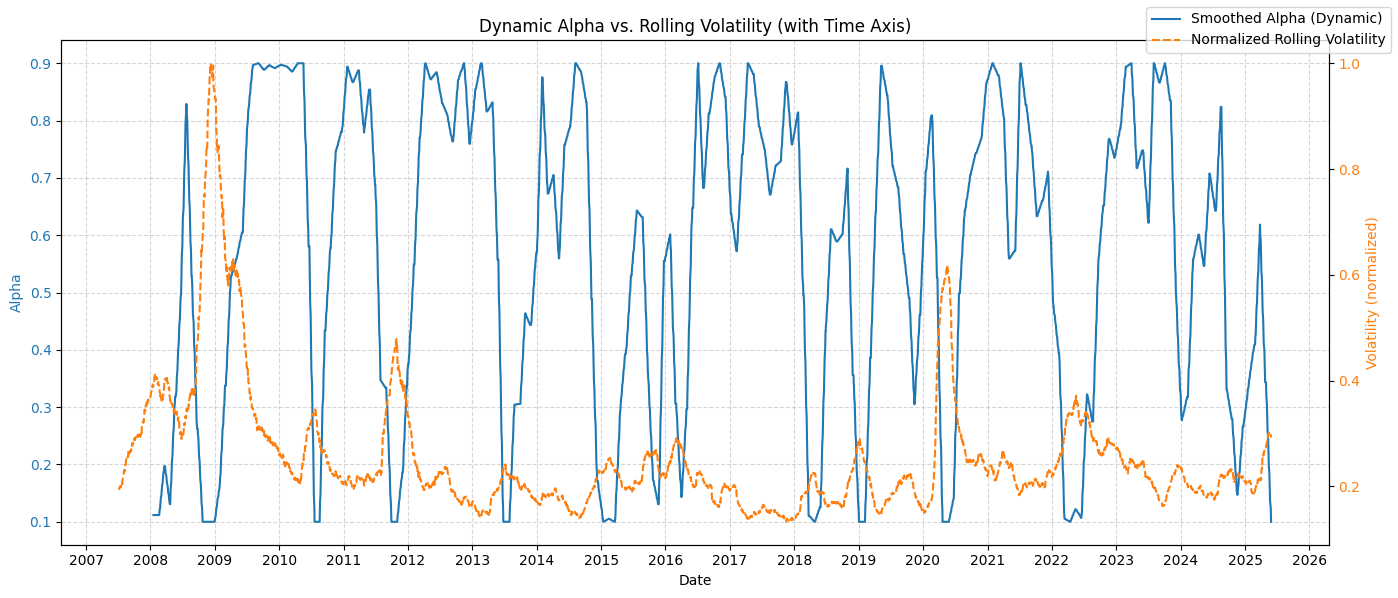

In [39]:
# 執行並繪圖檢查
alpha_monthly, rolling_vol_monthly = compute_dynamic_alpha_monthly(R)
plot_dynamic_alpha_with_dates(alpha_monthly, rolling_vol_monthly, dates=returns.index)

In [40]:
from tqdm import tqdm

def run_erc_backtest_with_marginal_gradient(returns, alpha_monthly, window=60, beta=0.95, max_weight=0.2, alpha_dates=None, return_dates=None):
    T, N = returns.shape
    weight_history = []
    portfolio_returns = []

    # 若提供 alpha_dates（每月），則建立 mapping
    if alpha_dates is not None and return_dates is not None:
        alpha_series = pd.Series(alpha_monthly, index=pd.to_datetime(alpha_dates))
        alpha_series = alpha_series.reindex(pd.to_datetime(return_dates), method='ffill').fillna(0.5).values
    else:
        alpha_series = alpha_monthly  # fallback to original behavior

    for t in tqdm(range(window, T)):
        R_window = returns[t - window: t]
        alpha_t = alpha_series[t]

        try:
            weights, _ = optimize_hybrid_erc(R_window, alpha=alpha_t, beta=beta, max_weight=max_weight)
        except:
            weights = np.ones(N) / N

        weight_history.append(weights)
        portfolio_returns.append(np.dot(returns[t], weights))

    return np.array(weight_history), np.array(portfolio_returns)

#def run_fixed_alpha_backtest(returns, alpha=0.5, **kwargs):
    #alpha_series = np.full(returns.shape[0], alpha)
    #return run_erc_backtest_with_marginal_gradient(returns, alpha_series, **kwargs) 

def run_fixed_alpha_backtest(returns, alpha, window=60, beta=0.95, max_weight=0.2):
    alpha_series = np.full(returns.shape[0], alpha)
    return run_erc_backtest_with_marginal_gradient(
        returns,
        alpha_monthly=alpha_series,
        window=window,
        beta=beta,
        max_weight=max_weight,
        alpha_dates=None,  # 明確設定為 None
        return_dates=None
    )



In [41]:
# 動態 alpha 策略
w_dynamic, r_dynamic = run_erc_backtest_with_marginal_gradient(R, alpha_monthly)

100%|██████████| 4503/4503 [09:12<00:00,  8.15it/s]


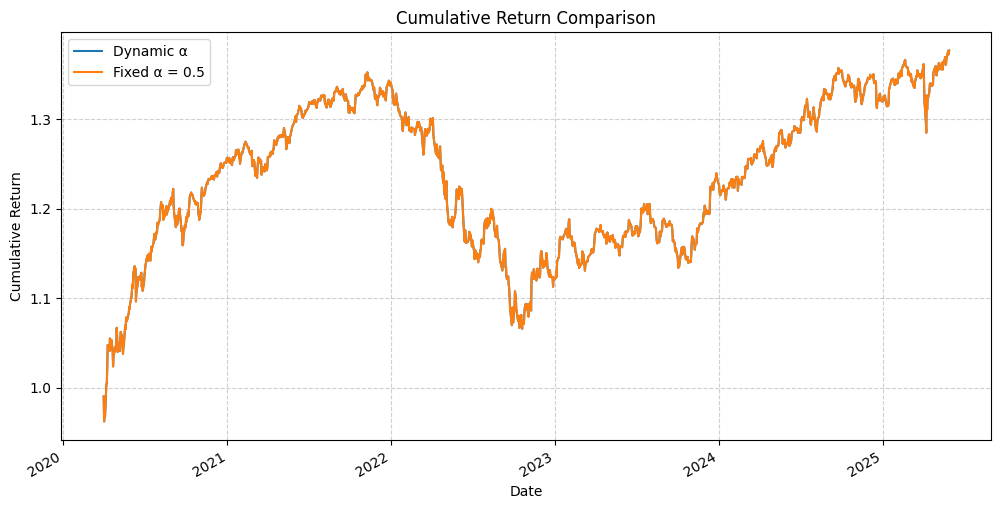

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_cumulative_returns(r1, r2, dates=None, labels=["Dynamic α", "Fixed α = 0.5"]):
    """
    r1, r2: 報酬率序列（長度 T）
    dates: datetime 日期序列（長度 T，可選）
    labels: 策略名稱
    """
    cum_r1 = np.cumprod(1 + r1)
    cum_r2 = np.cumprod(1 + r2)

    plt.figure(figsize=(12, 6))

    if dates is not None:
        plt.plot(dates[-len(cum_r1):], cum_r1, label=labels[0])
        plt.plot(dates[-len(cum_r2):], cum_r2, label=labels[1])
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # 每年一格
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.gcf().autofmt_xdate()
        plt.xlabel("Date")
    else:
        plt.plot(cum_r1, label=labels[0])
        plt.plot(cum_r2, label=labels[1])
        plt.xlabel("Time")

    plt.title("Cumulative Return Comparison")
    plt.ylabel("Cumulative Return")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# 假設 returns 是從第 60 天開始回測的：
plot_cumulative_returns(r_dynamic, r_fixed, dates=returns.index)

回測個策略報酬與風險表現

In [15]:
import cvxpy as cp
import numpy as np

def min_mad_weights(returns, max_weight=0.2):
    T, N = returns.shape
    w = cp.Variable(N)
    L = -returns
    mean_loss = cp.sum(L @ w) / T
    mad = cp.sum(cp.abs(L @ w - mean_loss)) / T
    constraints = [cp.sum(w) == 1, w >= 0, w <= max_weight]
    prob = cp.Problem(cp.Minimize(mad), constraints)
    prob.solve()
    return w.value

def min_cvar_weights(returns, beta=0.95, max_weight=0.2):
    T, N = returns.shape
    w = cp.Variable(N)
    zeta = cp.Variable()
    slack = cp.Variable(T)
    loss = -returns @ w
    cvar = zeta + cp.sum(slack) / ((1 - beta) * T)
    constraints = [slack >= 0, slack >= loss - zeta, cp.sum(w) == 1, w >= 0, w <= max_weight]
    prob = cp.Problem(cp.Minimize(cvar), constraints)
    prob.solve()
    return w.value

def min_variance_weights(returns, max_weight=0.2):
    N = returns.shape[1]
    Sigma = np.cov(returns.T)
    w = cp.Variable(N)
    variance = cp.quad_form(w, Sigma)
    constraints = [cp.sum(w) == 1, w >= 0, w <= max_weight]
    prob = cp.Problem(cp.Minimize(variance), constraints)
    prob.solve()
    return w.value


In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# MAD-ERC
def mad_erc_weights(R):
    T, N = R.shape
    def marginal_grad(w):
        L = -R @ w
        mu = np.mean(L)
        return np.mean(np.sign(L - mu).reshape(-1, 1) * -R, axis=0)
    def loss(w):
        grad = marginal_grad(w)
        rc = w * grad
        return np.sum((rc - rc.mean()) ** 2)
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 0.2)] * N
    w0 = np.ones(N) / N
    res = minimize(loss, w0, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x

# CVaR-ERC
def cvar_erc_weights(R, beta=0.95):
    T, N = R.shape
    def marginal_grad(w):
        L = -R @ w
        zeta = np.percentile(L, (1 - beta) * 100)
        indicator = (L > zeta).astype(float)
        return np.mean(indicator.reshape(-1, 1) * -R, axis=0) / (1 - beta)
    def loss(w):
        grad = marginal_grad(w)
        rc = w * grad
        return np.sum((rc - rc.mean()) ** 2)
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 0.2)] * N
    w0 = np.ones(N) / N
    res = minimize(loss, w0, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x

# Variance-ERC
def variance_erc_weights(R):
    N = R.shape[1]
    Sigma = np.cov(R.T)
    def risk_contribution(w):
        total = w.T @ Sigma @ w
        mrc = Sigma @ w
        rc = w * mrc
        return rc
    def loss(w):
        rc = risk_contribution(w)
        return np.sum((rc - rc.mean()) ** 2)
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 0.2)] * N
    w0 = np.ones(N) / N
    res = minimize(loss, w0, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x

# Hybrid ERC 主體
def optimize_hybrid_erc(R, alpha=0.5, beta=0.95, max_weight=0.2):
    T, N = R.shape
    ew = np.ones(N) / N
    L = -R @ ew
    mean_L = np.mean(L)
    mad_ew = np.mean(np.abs(L - mean_L))
    zeta = np.percentile(L, (1 - beta) * 100)
    slack = np.maximum(0, L - zeta)
    cvar_ew = zeta + np.sum(slack) / ((1 - beta) * len(R))
    def risk_contributions(w):
        L = -R @ w
        mean_L = np.mean(L)
        mad = np.mean(np.abs(L - mean_L))
        zeta = np.percentile(L, (1 - beta) * 100)
        slack = np.maximum(0, L - zeta)
        cvar = zeta + np.sum(slack) / ((1 - beta) * len(R))
        grad_mad = np.mean(np.sign(L - mean_L).reshape(-1, 1) * -R, axis=0)
        indicator = (L > zeta).astype(float)
        grad_cvar = np.mean(indicator.reshape(-1, 1) * -R, axis=0) / (1 - beta)
        grad = alpha * grad_mad / mad_ew + (1 - alpha) * grad_cvar / cvar_ew
        return w * grad
    def loss(w):
        rc = risk_contributions(w)
        return np.sum((rc - rc.mean()) ** 2)
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, max_weight)] * N
    w0 = np.ones(N) / N
    result = minimize(loss, w0, method='SLSQP', bounds=bounds, constraints=cons)
    return result.x, loss(result.x)

# 回測主體
from tqdm import tqdm
import numpy as np

def run_erc_backtest_with_marginal_gradient(returns, alpha_monthly, window=60, beta=0.95, max_weight=0.2):
    """
    使用動態 alpha 的 Hybrid ERC 回測框架
    """
    T, N = returns.shape
    weight_history = []
    portfolio_returns = []

    for t in tqdm(range(window, T)):
        R_window = returns[t - window: t]

        # 修正這行，支援 Series 或 numpy array
        alpha_t = alpha_monthly[t] if isinstance(alpha_monthly, np.ndarray) else alpha_monthly.iloc[t]

        try:
            weights, _ = optimize_hybrid_erc(R_window, alpha=alpha_t, beta=beta, max_weight=max_weight)
        except:
            weights = np.ones(N) / N

        weight_history.append(weights)
        portfolio_returns.append(np.dot(returns[t], weights))

    return np.array(weight_history), np.array(portfolio_returns)


def run_fixed_alpha_backtest(returns, alpha=0.5, **kwargs):
    alpha_series = np.full(returns.shape[0], alpha)
    return run_erc_backtest_with_marginal_gradient(returns, alpha_series, **kwargs)

# 績效計算
def compute_metrics(returns, rf=0.0001, scale=252):
    ann_return = np.mean(returns) * scale
    ann_vol = np.std(returns) * np.sqrt(scale)
    sharpe = (ann_return - rf) / ann_vol if ann_vol > 0 else np.nan
    cumulative = np.cumprod(1 + returns)
    running_max = np.maximum.accumulate(cumulative)
    drawdowns = 1 - cumulative / running_max
    max_drawdown = np.max(drawdowns)
    return {
        "Annual Return": ann_return,
        "Volatility": ann_vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_drawdown
    }

def summarize_strategies(strategy_returns_dict):
    summary = pd.DataFrame()
    for name, rets in strategy_returns_dict.items():
        metrics = compute_metrics(rets)
        summary[name] = pd.Series(metrics)
    return summary.T

def plot_cumulative_returns(strategy_returns_dict, dates=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    for name, rets in strategy_returns_dict.items():
        cumrets = np.cumprod(1 + rets)
        if dates is not None:
            plt.plot(dates[-len(cumrets):], cumrets, label=name)
        else:
            plt.plot(cumrets, label=name)
    plt.title("Cumulative Returns Comparison")
    plt.ylabel("Growth of $1")
    plt.xlabel("Date" if dates is not None else "Time")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# 整合所有策略
def run_benchmark_strategies(returns, alpha_series, alpha_fixed=0.5, max_weight=0.2):
    T, N = returns.shape
    equal_weight = np.repeat(1 / N, N)
    rets_equal = returns @ equal_weight

    # Hybrid ERC: dynamic alpha
    _, rets_dynamic = run_erc_backtest_with_marginal_gradient(returns, alpha_series, max_weight=max_weight)

    # Hybrid ERC: fixed alpha
    _, rets_fixed = run_fixed_alpha_backtest(returns, alpha=alpha_fixed, max_weight=max_weight)

    # Min-MAD
    w_mad = min_mad_weights(returns, max_weight=max_weight)
    rets_minmad = returns @ w_mad

    # Min-CVaR
    w_cvar = min_cvar_weights(returns, beta=0.95, max_weight=max_weight)
    rets_mincvar = returns @ w_cvar

    # Min-Variance
    w_var = min_variance_weights(returns, max_weight=max_weight)
    rets_minvar = returns @ w_var

    # MAD-ERC
    w_mad_erc = mad_erc_weights(returns)
    rets_mad_erc = returns @ w_mad_erc

    # CVaR-ERC
    w_cvar_erc = cvar_erc_weights(returns)
    rets_cvar_erc = returns @ w_cvar_erc

    # Variance-ERC
    w_var_erc = variance_erc_weights(returns)
    rets_var_erc = returns @ w_var_erc

    # 統整所有策略結果
    strategy_dict = {
        "Hybrid ERC (Dynamic α)": rets_dynamic,
        "Hybrid ERC (α=0.5)": rets_fixed,
        "Min-MAD": rets_minmad,
        "Min-CVaR": rets_mincvar,
        "Min-Variance": rets_minvar,
        "MAD-ERC": rets_mad_erc,
        "CVaR-ERC": rets_cvar_erc,
        "Variance-ERC": rets_var_erc,
        "Equal Weight": rets_equal
    }

    return strategy_dict


# 執行範例
# alpha_series 為長度 T 的 alpha array，returns 為 T x N 報酬矩陣
# strategy_dict = run_strategies_without_cvxpy(returns, alpha_series)
# performance_summary = summarize_strategies(strategy_dict)
# plot_cumulative_returns(strategy_dict, dates=returns.index)


In [42]:
def run_benchmark_strategies(returns, alpha_series_dynamic, window=60):
    T, N = returns.shape
    equal_weight = np.repeat(1 / N, N)
    rets_equal = returns @ equal_weight

    # Hybrid ERC: dynamic α
    _, rets_dynamic = run_erc_backtest_with_marginal_gradient(
        returns,
        alpha_monthly=alpha_series_dynamic,
        window=window,
        alpha_dates=None,
        return_dates=None
    )

    # Fixed α = 0.0 (CVaR-ERC), α = 0.5 (Hybrid), α = 1.0 (MAD-ERC)
    _, rets_alpha0 = run_fixed_alpha_backtest(returns, alpha=0.0, window=window)
    _, rets_alpha05 = run_fixed_alpha_backtest(returns, alpha=0.5, window=window)
    _, rets_alpha1 = run_fixed_alpha_backtest(returns, alpha=1.0, window=window)

    # Min-MAD
    w = cp.Variable(N)
    L = -returns
    mean_loss = cp.sum(L @ w) / T
    mad = cp.sum(cp.abs(L @ w - mean_loss)) / T
    prob = cp.Problem(cp.Minimize(mad), [cp.sum(w) == 1, w >= 0, w <= 0.2])
    prob.solve()
    w_mad = w.value
    rets_minmad = returns @ w_mad

    # Min-CVaR
    w = cp.Variable(N)
    zeta = cp.Variable()
    slack = cp.Variable(T)
    loss = -returns @ w
    cvar = zeta + cp.sum(slack) / ((1 - 0.95) * T)
    constraints = [slack >= 0, slack >= loss - zeta, cp.sum(w) == 1, w >= 0, w <= 0.2]
    prob = cp.Problem(cp.Minimize(cvar), constraints)
    prob.solve()
    w_cvar = w.value
    rets_mincvar = returns @ w_cvar

    strategy_dict = {
        "Hybrid ERC (Dynamic α)": rets_dynamic,
        "Hybrid ERC (α=0.5)": rets_alpha05,
        "MAD-ERC (α=1.0)": rets_alpha1,
        "CVaR-ERC (α=0.0)": rets_alpha0,
        "Min-MAD": rets_minmad,
        "Min-CVaR": rets_mincvar,
        "Equal Weight": rets_equal
    }

    return strategy_dict


100%|██████████| 4503/4503 [08:28<00:00,  8.86it/s]


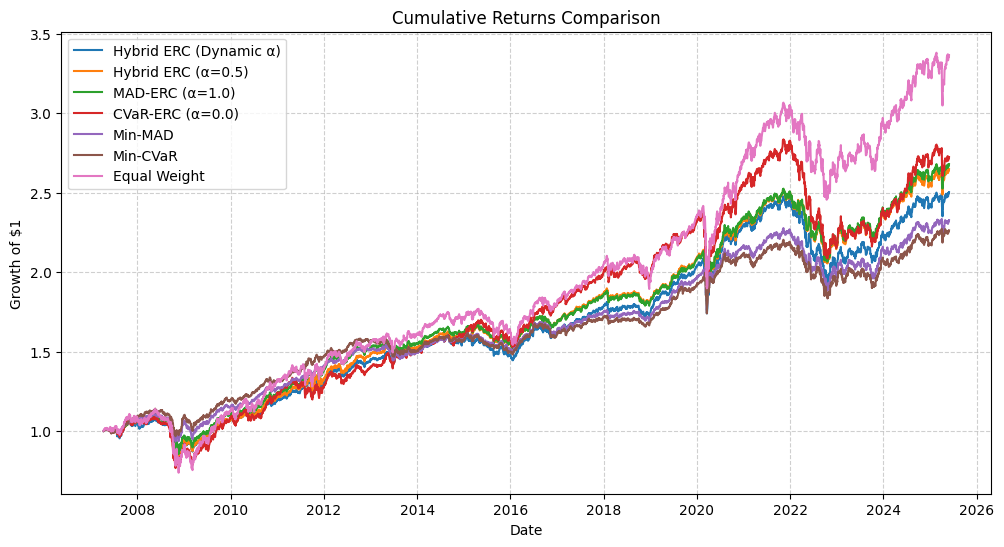

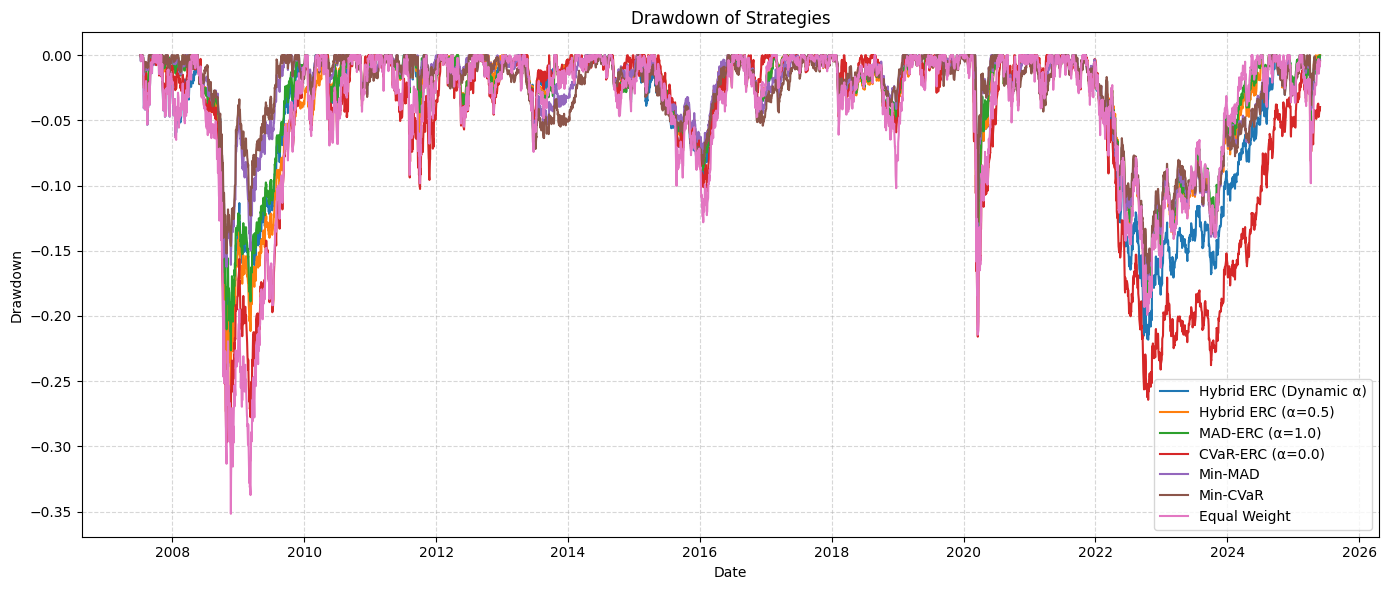

In [43]:
strategy_dict = run_benchmark_strategies(R, alpha_series_dynamic=alpha_monthly)
performance_summary = summarize_strategies(strategy_dict)
plot_cumulative_returns(strategy_dict, dates=returns.index)
plot_drawdowns(strategy_dict, dates=returns.index)

In [44]:
import pandas as pd
from IPython.display import display

display(performance_summary.style.format("{:.4f}"))

,Annual Return,Volatility,Sharpe,Max Drawdown
Hybrid ERC (Dynamic α),0.0546,0.0807,0.6759,0.2415
Hybrid ERC (α=0.5),0.0575,0.0775,0.7407,0.2562
MAD-ERC (α=1.0),0.0581,0.0760,0.7632,0.2264
CVaR-ERC (α=0.0),0.0608,0.0968,0.6266,0.2972
Min-MAD,0.0487,0.0634,0.7658,0.1720
Min-CVaR,0.0471,0.0627,0.7490,0.1674
Equal Weight,0.0745,0.1221,0.6093,0.3517


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 評估指標計算函數
def compute_metrics(returns, rf=0.0001, scale=252):
    """
    計算年化報酬、波動度、Sharpe、最大回撤
    """
    ann_return = np.mean(returns) * scale
    ann_vol = np.std(returns) * np.sqrt(scale)
    sharpe = (ann_return - rf) / ann_vol if ann_vol > 0 else np.nan

    cumulative = np.cumprod(1 + returns)
    running_max = np.maximum.accumulate(cumulative)
    drawdowns = 1 - cumulative / running_max
    max_drawdown = np.max(drawdowns)

    return {
        "Annual Return": ann_return,
        "Volatility": ann_vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_drawdown
    }

# 策略報酬字典與績效表整理
def summarize_strategies(strategy_returns_dict):
    summary = pd.DataFrame()
    for name, rets in strategy_returns_dict.items():
        metrics = compute_metrics(rets)
        summary[name] = pd.Series(metrics)
    return summary.T

# 累積報酬視覺化
def plot_cumulative_returns(strategy_returns_dict, dates=None):
    plt.figure(figsize=(12, 6))
    for name, rets in strategy_returns_dict.items():
        cumrets = np.cumprod(1 + rets)
        if dates is not None:
            plt.plot(dates[-len(cumrets):], cumrets, label=name)
        else:
            plt.plot(cumrets, label=name)
    plt.title("Cumulative Returns Comparison")
    plt.ylabel("Growth of $1")
    plt.xlabel("Date" if dates is not None else "Time")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

Hybrid 動態、固定、EW、MAD-ERC、CVaR-ERC、Variance-ERC

Min-MAD、Min-CVaR

In [18]:
def mad_erc_weights(R):
    T, N = R.shape

    def marginal_grad(w):
        L = -R @ w
        mu = np.mean(L)
        return np.mean(np.sign(L - mu).reshape(-1, 1) * -R, axis=0)

    def loss(w):
        grad = marginal_grad(w)
        rc = w * grad
        return np.sum((rc - rc.mean()) ** 2)

    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 0.2)] * N
    w0 = np.ones(N) / N

    res = minimize(loss, w0, method='SLSQP', bounds=bounds, constraints=cons)

    if not res.success:
        print("⚠️ MAD-ERC optimization failed, fallback to equal weight.")
        return np.ones(N) / N

    return res.x


In [19]:
def cvar_erc_weights(R, beta=0.95):
    T, N = R.shape

    def marginal_grad(w):
        L = -R @ w
        zeta = np.percentile(L, (1 - beta) * 100)
        indicator = (L > zeta).astype(float)
        return np.mean(indicator.reshape(-1, 1) * -R, axis=0) / (1 - beta)

    def loss(w):
        grad = marginal_grad(w)
        rc = w * grad
        return np.sum((rc - rc.mean()) ** 2)

    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 0.2)] * N
    w0 = np.ones(N) / N

    res = minimize(loss, w0, method='SLSQP', bounds=bounds, constraints=cons)

    if not res.success:
        print("⚠️ CVaR-ERC optimization failed, fallback to equal weight.")
        return np.ones(N) / N

    return res.x


In [20]:
def variance_erc_weights(R):
    N = R.shape[1]
    Sigma = np.cov(R.T)

    def risk_contribution(w):
        mrc = Sigma @ w
        rc = w * mrc
        return rc

    def loss(w):
        rc = risk_contribution(w)
        return np.sum((rc - rc.mean()) ** 2)

    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 0.2)] * N
    w0 = np.ones(N) / N

    res = minimize(loss, w0, method='SLSQP', bounds=bounds, constraints=cons)

    if not res.success:
        print("⚠️ Variance-ERC optimization failed, fallback to equal weight.")
        return np.ones(N) / N

    return res.x


In [28]:
import cvxpy as cp
import scipy.optimize as sco

新增

In [29]:
def variance_erc_weights(returns):
    cov = np.cov(returns.T)
    N = cov.shape[0]

    def risk_contribution(w):
        port_var = w @ cov @ w
        rc = w * (cov @ w)
        return rc

    def obj(w):
        rc = risk_contribution(w)
        return np.sum((rc - np.mean(rc)) ** 2)

    w0 = np.repeat(1/N, N)
    bounds = [(0, 0.2)] * N
    cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    res = sco.minimize(obj, w0, bounds=bounds, constraints=cons)
    return res.x

def cvar_erc_weights(returns, beta=0.95):
    T, N = returns.shape
    w = cp.Variable(N)
    zeta = cp.Variable()
    xi = cp.Variable(T)

    loss = -returns @ w
    cvar = zeta + cp.sum(xi) / ((1 - beta) * T)
    constraints = [
        xi >= 0,
        xi >= loss - zeta,
        cp.sum(w) == 1,
        w >= 0,
        w <= 0.2
    ]
    prob = cp.Problem(cp.Minimize(cvar), constraints)
    prob.solve()
    w_val = w.value
    return w_val

def mad_erc_weights(returns):
    T, N = returns.shape
    L = -returns
    w = cp.Variable(N)
    mean_loss = cp.sum(L @ w) / T
    mad = cp.sum(cp.abs(L @ w - mean_loss)) / T
    constraints = [cp.sum(w) == 1, w >= 0, w <= 0.2]
    prob = cp.Problem(cp.Minimize(mad), constraints)
    prob.solve()
    return w.value


In [30]:
def run_benchmark_strategies(returns, alpha_series, alpha_fixed=0.5):
    T, N = returns.shape
    equal_weight = np.repeat(1 / N, N)
    rets_equal = returns @ equal_weight

    # Hybrid ERC: dynamic and fixed alpha
    _, rets_dynamic = run_erc_backtest_with_marginal_gradient(returns, alpha_series)
    _, rets_fixed = run_fixed_alpha_backtest(returns, alpha_fixed)

    # Min-MAD
    w = cp.Variable(N)
    L = -returns
    mean_loss = cp.sum(L @ w) / T
    mad = cp.sum(cp.abs(L @ w - mean_loss)) / T
    prob = cp.Problem(cp.Minimize(mad), [cp.sum(w) == 1, w >= 0, w <= 0.2])
    prob.solve()
    w_mad = w.value
    rets_minmad = returns @ w_mad

    # Min-CVaR
    w = cp.Variable(N)
    zeta = cp.Variable()
    slack = cp.Variable(T)
    loss = -returns @ w
    cvar = zeta + cp.sum(slack) / ((1 - 0.95) * T)
    constraints = [slack >= 0, slack >= loss - zeta, cp.sum(w) == 1, w >= 0, w <= 0.2]
    prob = cp.Problem(cp.Minimize(cvar), constraints)
    prob.solve()
    w_cvar = w.value
    rets_mincvar = returns @ w_cvar

    # Variance-ERC
    w_var_erc = variance_erc_weights(returns)
    rets_var_erc = returns @ w_var_erc

    # MAD-ERC
    w_mad_erc = mad_erc_weights(returns)
    rets_mad_erc = returns @ w_mad_erc

    # CVaR-ERC
    w_cvar_erc = cvar_erc_weights(returns, beta=0.95)
    rets_cvar_erc = returns @ w_cvar_erc

    strategy_dict = {
        "Hybrid ERC (Dynamic α)": rets_dynamic,
        "Hybrid ERC (α=0.5)": rets_fixed,
        "Equal Weight": rets_equal,
        "Min-MAD": rets_minmad,
        "Min-CVaR": rets_mincvar,
        "Variance-ERC": rets_var_erc,
        "MAD-ERC": rets_mad_erc,
        "CVaR-ERC": rets_cvar_erc
    }

    return strategy_dict


100%|██████████| 1298/1298 [02:30<00:00,  8.62it/s]


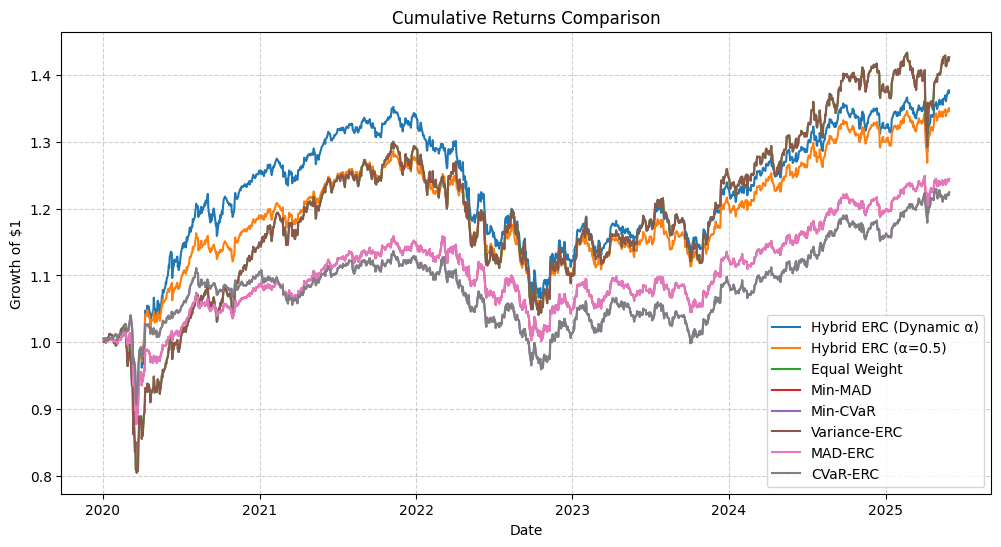

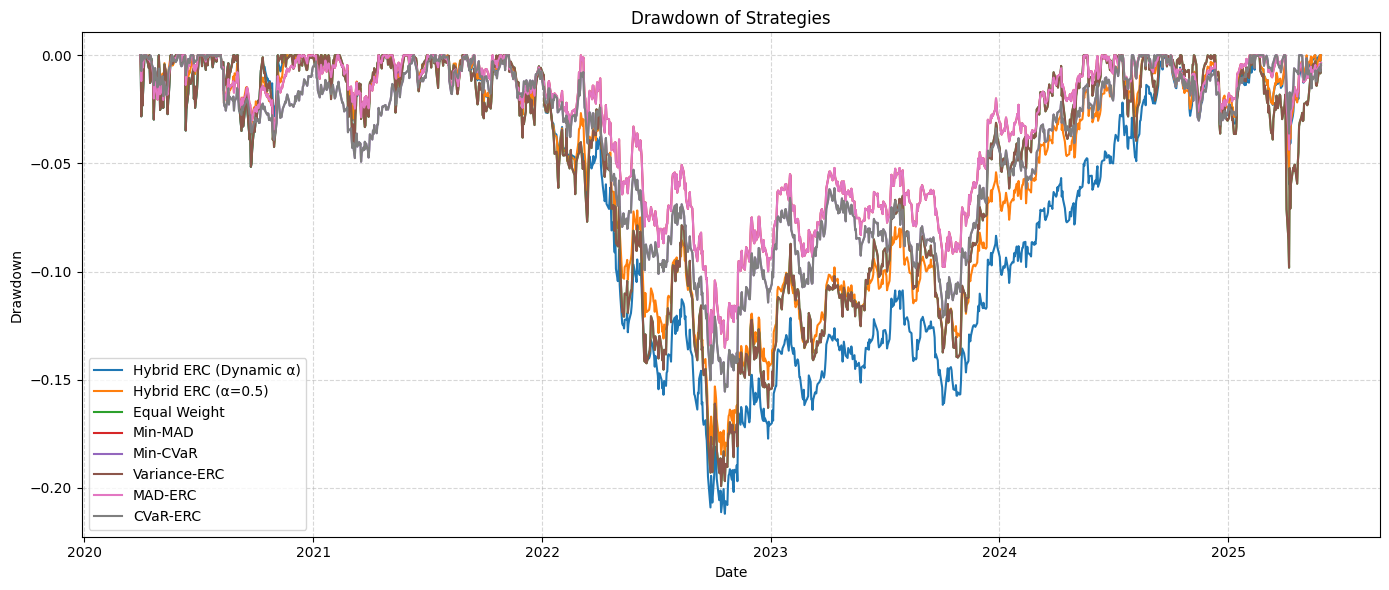

In [31]:
strategy_dict = run_benchmark_strategies(R, alpha_monthly)
performance_summary = summarize_strategies(strategy_dict)
plot_cumulative_returns(strategy_dict, dates=returns.index)
plot_drawdowns(strategy_dict, dates=returns.index)


100%|██████████| 1298/1298 [02:25<00:00,  8.91it/s]


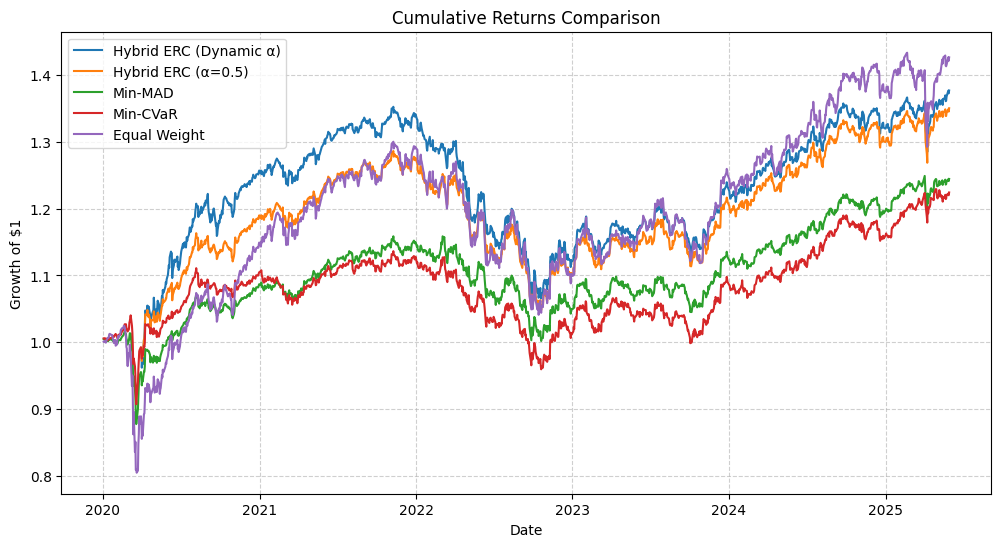

In [ ]:
import cvxpy as cp
# 執行所有策略（Hybrid 動態、固定、Min-MAD、Min-CVaR、MAD-ERC、CVaR-ERC、EW）
def run_benchmark_strategies(returns, alpha_series, alpha_fixed=0.5):
    T, N = returns.shape
    equal_weight = np.repeat(1 / N, N)
    rets_equal = returns @ equal_weight

    # Hybrid ERC: dynamic and fixed alpha
    _, rets_dynamic = run_erc_backtest_with_marginal_gradient(returns, alpha_series)
    _, rets_fixed = run_fixed_alpha_backtest(returns, alpha_fixed)

    # Min-MAD
    w = cp.Variable(N)
    L = -returns
    mean_loss = cp.sum(L @ w) / T
    mad = cp.sum(cp.abs(L @ w - mean_loss)) / T
    prob = cp.Problem(cp.Minimize(mad), [cp.sum(w) == 1, w >= 0, w <= 0.2])
    prob.solve()
    w_mad = w.value
    rets_minmad = returns @ w_mad

    # Min-CVaR
    w = cp.Variable(N)
    zeta = cp.Variable()
    slack = cp.Variable(T)
    loss = -returns @ w
    cvar = zeta + cp.sum(slack) / ((1 - 0.95) * T)
    constraints = [slack >= 0, slack >= loss - zeta, cp.sum(w) == 1, w >= 0, w <= 0.2]
    prob = cp.Problem(cp.Minimize(cvar), constraints)
    prob.solve()
    w_cvar = w.value
    rets_mincvar = returns @ w_cvar

    # MAD-ERC
    #w_mad_erc = mad_erc_weights(returns)
    #rets_mad_erc = returns @ w_mad_erc

    # CVaR-ERC
    #w_cvar_erc = cvar_erc_weights(returns, beta=0.95)
    #rets_cvar_erc = returns @ w_cvar_erc

    # Variance-ERC
    #w_var_erc = variance_erc_weights(returns)
    #rets_var_erc = returns @ w_var_erc

    strategy_dict = {
        "Hybrid ERC (Dynamic α)": rets_dynamic,
        "Hybrid ERC (α=0.5)": rets_fixed,
        "Min-MAD": rets_minmad,
        "Min-CVaR": rets_mincvar,
        "Equal Weight": rets_equal
    }

    return strategy_dict


# 執行策略與統整績效
strategy_dict = run_benchmark_strategies(R, alpha_monthly)

performance_summary = summarize_strategies(strategy_dict)
plot_cumulative_returns(strategy_dict, dates=returns.index)

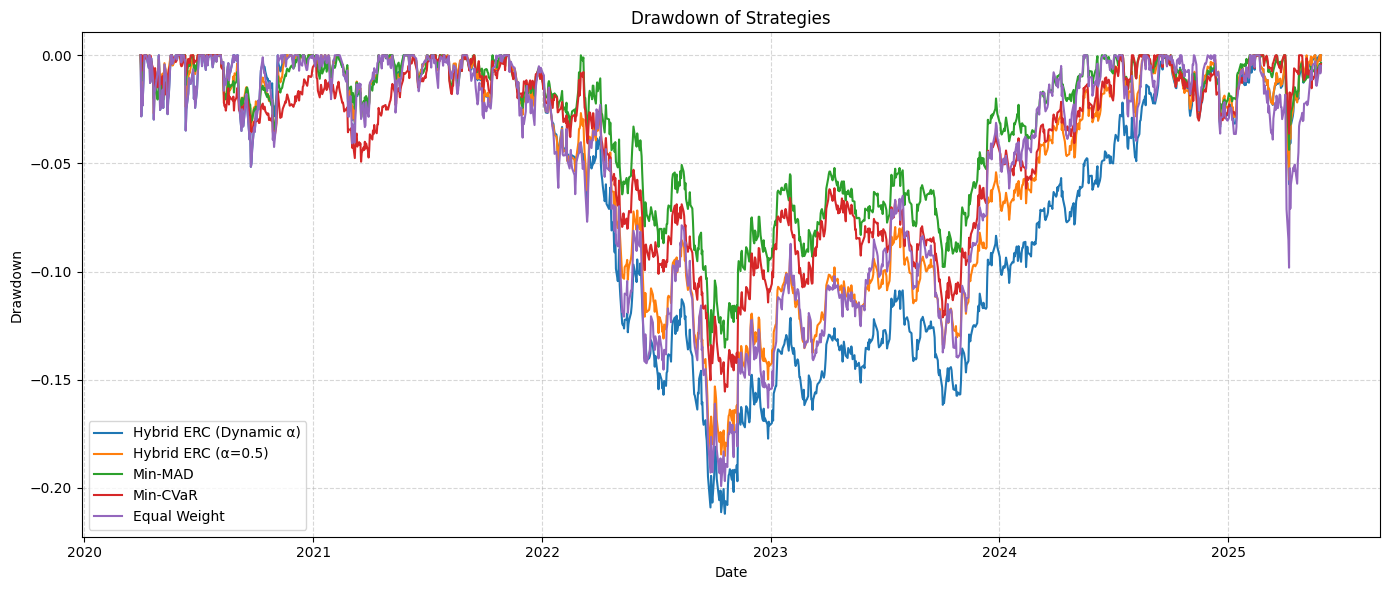

In [25]:
def plot_drawdowns(strategy_dict, dates=None):
    """
    繪製每個策略的 Drawdown 時序圖，並自動對齊時間長度。
    """
    min_len = min(len(r) for r in strategy_dict.values())
    if dates is not None:
        dates = dates[-min_len:]

    plt.figure(figsize=(14, 6))
    for name, rets in strategy_dict.items():
        rets_trimmed = rets[-min_len:]  # 確保一致長度
        cum_returns = (1 + pd.Series(rets_trimmed, index=dates)).cumprod()
        rolling_max = cum_returns.cummax()
        drawdown = cum_returns / rolling_max - 1
        plt.plot(drawdown.index, drawdown, label=name)

    plt.title('Drawdown of Strategies')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_drawdowns(strategy_dict, dates=returns.index)

In [42]:
strategy_dict

{'Hybrid ERC (Dynamic α)': array([-0.00996786, -0.0282218 ,  0.01295239, ...,  0.00654243,
        -0.00283313,  0.00306919], shape=(1298,)),
 'Hybrid ERC (α=0.5)': array([-0.01086843, -0.01723653,  0.01043061, ...,  0.00422178,
        -0.00261887,  0.00371547], shape=(1298,)),
 'Min-MAD': array([ 4.85418419e-03,  4.07122194e-06, -1.04914248e-03, ...,
         2.80662695e-03, -2.21429813e-03,  2.58618154e-03], shape=(1358,)),
 'Min-CVaR': array([ 0.00588255,  0.00022426, -0.00080853, ...,  0.00181961,
        -0.00207754,  0.00342311], shape=(1358,)),
 'MAD-ERC': array([ 0.00098191,  0.00111694, -0.00210693, ...,  0.00803398,
        -0.00363565,  0.00351733], shape=(1358,)),
 'CVaR-ERC': array([ 0.00098191,  0.00111694, -0.00210693, ...,  0.00803398,
        -0.00363565,  0.00351733], shape=(1358,)),
 'Equal Weight': array([ 0.00098191,  0.00111694, -0.00210693, ...,  0.00803398,
        -0.00363565,  0.00351733], shape=(1358,)),
 'Variance-ERC': array([ 0.00098191,  0.00111694, -0.0

In [22]:
import pandas as pd
from IPython.display import display

display(performance_summary.style.format("{:.4f}"))

,Annual Return,Volatility,Sharpe,Max Drawdown
Hybrid ERC (Dynamic α),0.0661,0.0895,0.7371,0.2119
Hybrid ERC (α=0.5),0.0617,0.0829,0.7436,0.1852
Min-MAD,0.0435,0.0759,0.5710,0.1361
Min-CVaR,0.0404,0.0759,0.5310,0.1554
Equal Weight,0.0739,0.1264,0.5837,0.2144


改良版

In [25]:
import scipy.optimize as sco

# 計算 MAD 的函數
def compute_mad(R, w):
    port_returns = R @ w
    mad = np.mean(np.abs(port_returns - np.mean(port_returns)))
    return mad

# 計算 CVaR 的函數（95% 信賴水準）
def compute_cvar(R, w, alpha=0.95):
    port_returns = R @ w
    var = np.percentile(port_returns, 100 * (1 - alpha))
    cvar = -np.mean(port_returns[port_returns <= var])
    return cvar

# 計算風險貢獻（Hybrid RC）
def compute_risk_contribution(R, w, alpha_mixture=0.5):
    mad = compute_mad(R, w)
    cvar = compute_cvar(R, w)
    hybrid_risk = alpha_mixture * mad + (1 - alpha_mixture) * cvar

    marginal_risk = np.zeros_like(w)
    epsilon = 1e-6
    for i in range(len(w)):
        w_perturbed = w.copy()
        w_perturbed[i] += epsilon
        mad_perturbed = compute_mad(R, w_perturbed)
        cvar_perturbed = compute_cvar(R, w_perturbed)
        hybrid_perturbed = alpha_mixture * mad_perturbed + (1 - alpha_mixture) * cvar_perturbed
        marginal_risk[i] = (hybrid_perturbed - hybrid_risk) / epsilon

    total_risk = hybrid_risk
    RC = w * marginal_risk
    return RC, total_risk

# ERC loss function + variance constraint
def objective(w, R, Sigma, alpha_mixture):
    RC, _ = compute_risk_contribution(R, w, alpha_mixture)
    rc_mean = np.mean(RC)
    loss = np.sum((RC - rc_mean) ** 2)
    return loss

# 優化函數（帶入 ε-constraint）
def optimize_erc_with_variance_constraint(R, Sigma, theta, alpha_mixture=0.5):
    n = R.shape[1]
    w0 = np.ones(n) / n

    cons = (
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "ineq", "fun": lambda w: theta - (w.T @ Sigma @ w)},
    )

    bounds = tuple((0, 1) for _ in range(n))

    result = sco.minimize(
        objective,
        w0,
        args=(R, Sigma, alpha_mixture),
        method="SLSQP",
        constraints=cons,
        bounds=bounds,
        options={"disp": False, "maxiter": 100}
    )
    if result.success:
        weights = result.x
        returns = R @ weights
        return weights, returns

In [26]:
# 執行
Sigma = np.cov(R.T)
theta = 0.0895
weights, port_returns = optimize_erc_with_variance_constraint(R, Sigma, theta)

In [27]:
strategy_dict["Hybrid ERC + Variance"] = port_returns

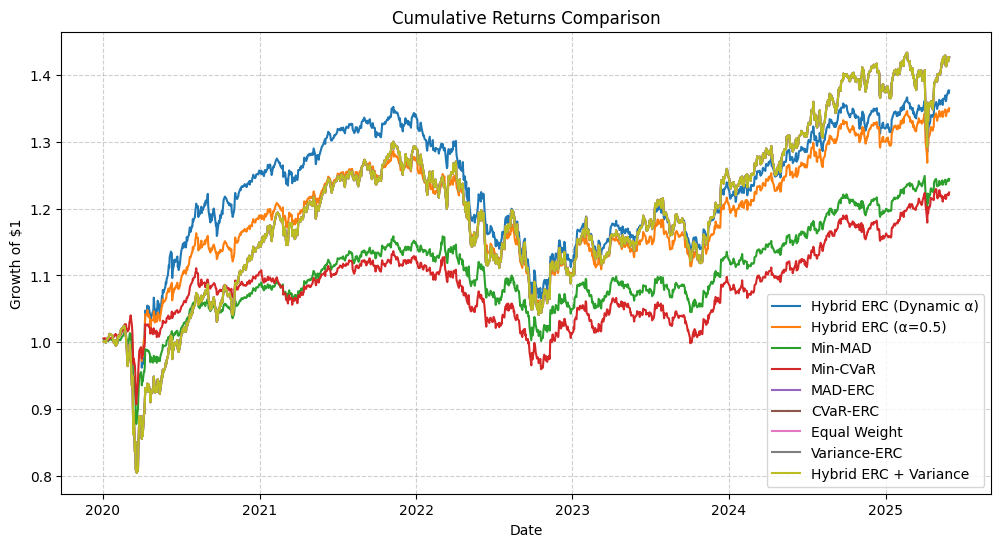

In [28]:
performance_summary = summarize_strategies(strategy_dict)
plot_cumulative_returns(strategy_dict, dates=returns.index)

In [30]:
import pandas as pd
from IPython.display import display

display(performance_summary.style.format("{:.4f}"))


,Annual Return,Volatility,Sharpe,Max Drawdown
Hybrid ERC (Dynamic α),0.0661,0.0895,0.7371,0.2119
Hybrid ERC (α=0.5),0.0617,0.0829,0.7436,0.1852
Min-MAD,0.0435,0.0759,0.5710,0.1361
Min-CVaR,0.0404,0.0759,0.5310,0.1554
MAD-ERC,0.0739,0.1264,0.5837,0.2144
CVaR-ERC,0.0739,0.1264,0.5837,0.2144
Equal Weight,0.0739,0.1264,0.5837,0.2144
Variance-ERC,0.0739,0.1264,0.5837,0.2144
Hybrid ERC + Variance,0.0739,0.1264,0.5837,0.2144


台灣

In [ ]:
etf_data = pd.read_csv("etf_data_taiwan.csv", index_col=0, parse_dates=True)
#etf_data = etf_data.loc["2020-01-01":"2025-05-30"]

不同 α 值下的 sensitivity 測試？（繪製權重 vs. α）

In [23]:
def grid_search_alpha(R, alphas, beta=0.95, tickers=None):
    """
    對不同 alpha 進行 Hybrid ERC grid search
    R: T x N 報酬矩陣
    alphas: alpha 值清單，例如 np.linspace(0, 1, 21)
    tickers: ETF 名稱（如有）
    回傳: 每個 alpha 對應的 weights 與 objective value
    """
    weight_matrix = []
    objective_list = []

    for alpha in alphas:
        weights, obj = optimize_hybrid_erc(R, alpha=alpha, beta=beta)
        weight_matrix.append(weights)
        objective_list.append(obj)

    weight_matrix = np.array(weight_matrix)  # len(alphas) x N
    objective_list = np.array(objective_list)

    # 若有 tickers，畫圖
    if tickers is not None:
        plt.figure(figsize=(12, 6))
        for i, ticker in enumerate(tickers):
            plt.plot(alphas, weight_matrix[:, i], label=ticker)
        plt.title("Weight Paths Across α (Hybrid ERC)")
        plt.xlabel("Alpha (α)")
        plt.ylabel("Asset Weight")
        plt.legend(loc='upper right')
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

        # 畫 Objective Value
        plt.figure(figsize=(10, 4))
        plt.plot(alphas, objective_list, marker='o')
        plt.title("ERC Objective Value Across α")
        plt.xlabel("Alpha (α)")
        plt.ylabel("Objective (RC Variance)")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    return weight_matrix, objective_list


#### 投資組合
1. 美國 All Weather Portfolio
2. 台灣大盤，超過50%權重


HYG 2007年4月才有

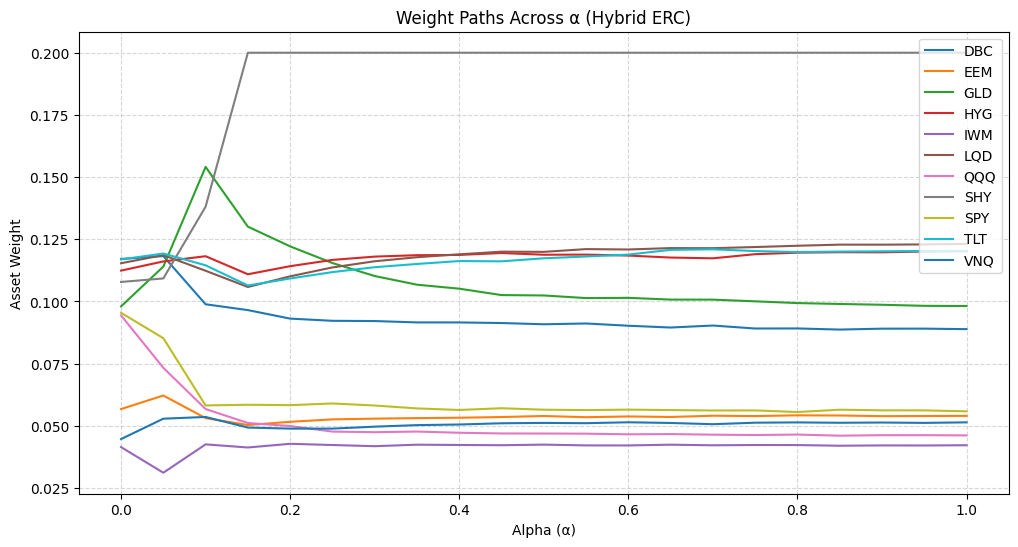

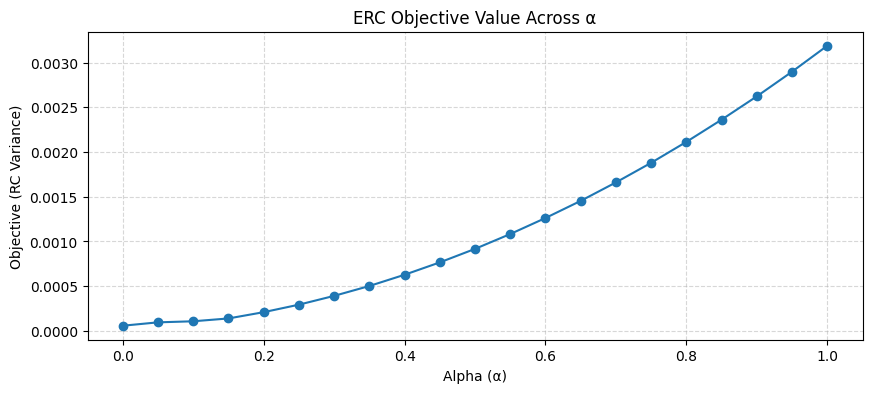

In [24]:
returns = etf_data.pct_change().dropna()
R = returns.values

alphas = np.linspace(0, 1, 21)  # α from 0.0 to 1.0
tickers = list(etf_data.columns)

weight_matrix, objective_list = grid_search_alpha(R, alphas, tickers=tickers)

In [25]:
best_idx = np.argmin(objective_list)
best_alpha = alphas[best_idx]
best_weights = weight_matrix[best_idx]

print(f"Best α: {best_alpha:.2f}")
print("Best Weights:")
for ticker, weight in zip(tickers, best_weights):
    print(f"{ticker}: {weight:.4f}")

Best α: 0.00
Best Weights:
DBC: 0.1171
EEM: 0.0567
GLD: 0.0980
HYG: 0.1124
IWM: 0.0414
LQD: 0.1153
QQQ: 0.0944
SHY: 0.1078
SPY: 0.0954
TLT: 0.1169
VNQ: 0.0446


 成功趨近 ERC
大部分資產 RC 集中在 0.004 ~ 0.0055 區間

雖仍有些許誤差（可視為 tolerance level 之內）

❗ 針對 SHY 與 GLD 的 RC 建議觀察
若權重偏高但 RC 幾乎為 0（甚至負），應觀察是否：

報酬資料中該資產表現極穩（無尾端風險）

slack 的參數過敏（尤其 CVaR beta 太高）



In [27]:
def evaluate_erc_contributions(w, R, alpha, beta, tickers, threshold=0.1):
    """
    計算風險貢獻統計（標準差、最大最小），並列出 ERC 評估報表
    """
    # 基準風險計算
    ew = np.ones(len(w)) / len(w)
    mad_ew = np.mean(np.abs(-R @ ew - np.mean(-R @ ew)))
    L_ew = -R @ ew
    zeta_ew = np.percentile(L_ew, (1 - beta) * 100)
    slack_ew = np.maximum(0, L_ew - zeta_ew)
    cvar_ew = zeta_ew + np.sum(slack_ew) / ((1 - beta) * len(R))

    # 計算風險貢獻
    RC = risk_contributions(w, R, alpha, beta, mad_ew, cvar_ew)

    # 統計資訊
    rc_mean = np.mean(RC)
    rc_std = np.std(RC)
    rc_min = np.min(RC)
    rc_max = np.max(RC)
    rc_cv = rc_std / rc_mean

    # ERC 偏離程度
    is_pass = rc_cv < threshold

    # 整理結果
    rc_df = pd.DataFrame({
        "Ticker": tickers,
        "RC": RC
    }).sort_values("RC", ascending=False).reset_index(drop=True)

    print("=== ERC Risk Contribution 統計檢定報告 ===")
    print(f"平均值: {rc_mean:.6f}")
    print(f"標準差: {rc_std:.6f}")
    print(f"最大值: {rc_max:.6f}")
    print(f"最小值: {rc_min:.6f}")
    print(f"變異係數 (std/mean): {rc_cv:.2%}")
    print(f"ERC 合格（變異係數 < {threshold:.0%}）: {'✅ 是' if is_pass else '❌ 否'}")

    return rc_df, is_pass


def plot_tail_loss_distribution(R, w, beta=0.95, tickers=None):
    """
    繪製各資產在 tail event（CVaR quantile）時的虧損分布
    """
    portfolio_losses = -R @ w
    quantile_threshold = np.percentile(portfolio_losses, (1 - beta) * 100)
    tail_idx = portfolio_losses <= quantile_threshold
    tail_returns = R[tail_idx]  # T_tail x N

    plt.figure(figsize=(12, 6))
    for i in range(tail_returns.shape[1]):
        sns.kdeplot(tail_returns[:, i], label=tickers[i] if tickers else f"Asset {i}")
    plt.title(f"Return Distributions under Tail Risk Event (bottom {(1-beta)*100:.0f}%)")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()


In [28]:
rc_df, is_pass = evaluate_erc_contributions(best_weights, R, alpha=best_alpha, beta=0.95, tickers=tickers)

=== ERC Risk Contribution 統計檢定報告 ===
平均值: 0.004004
標準差: 0.002298
最大值: 0.006030
最小值: -0.001054
變異係數 (std/mean): 57.38%
ERC 合格（變異係數 < 10%）: ❌ 否


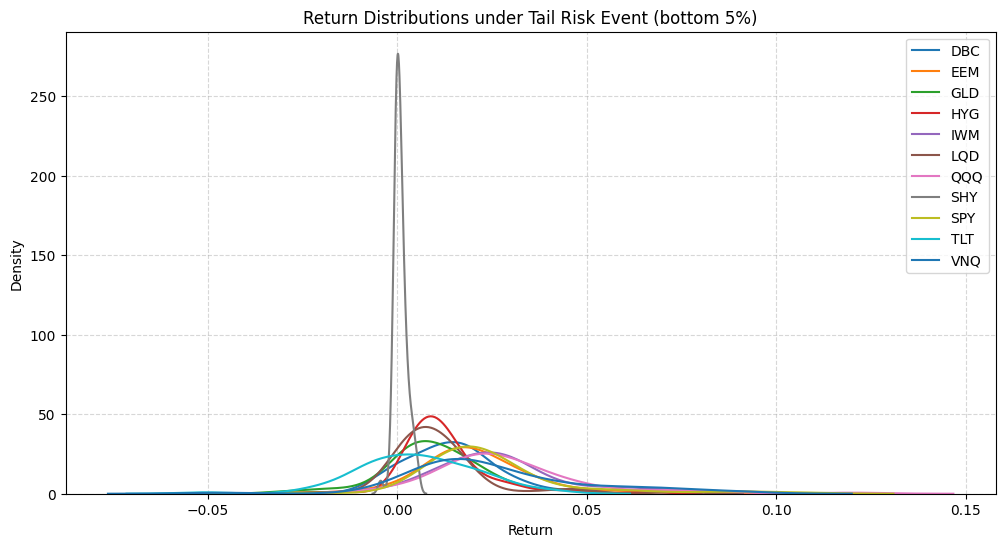

In [29]:
plot_tail_loss_distribution(R, best_weights, beta=0.95, tickers=tickers)

重點觀察：
SHY 報酬密度極高且接近 0 → 幾乎不受 tail event 影響 → 解釋了它的 RC 為負

大多數 ETF 在 tail event 場景下仍有正報酬（右偏） → CVaR 強調的風險反而沒明顯出現

GLD, TLT, SHY 是經典的避險資產，在 tail loss 場景中表現穩定，RC 自然偏低



In [273]:
# 重新匯入需要的套件與資料（因執行環境 reset）
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 檢查是否有資料、函數需要重新載入
import warnings
warnings.filterwarnings("ignore")

# 準備核心風險貢獻函數
def risk_contributions(w, R, alpha, beta, mad_val=None, cvar_val=None):
    T, N = R.shape
    L = -R @ w
    mean_loss = np.mean(L)
    mad_rc = np.abs(L - mean_loss).mean() if mad_val is None else mad_val
    zeta = np.percentile(L, (1 - beta) * 100)
    slack = np.maximum(0, L - zeta)
    cvar_rc = zeta + slack.sum() / ((1 - beta) * T) if cvar_val is None else cvar_val

    grad_mad = np.mean(np.sign(L - mean_loss)[:, np.newaxis] * (-R), axis=0)
    grad_cvar = np.mean((L > zeta)[:, np.newaxis] * (-R), axis=0) / (1 - beta)

    total_grad = alpha * grad_mad + (1 - alpha) * grad_cvar
    RC = w * total_grad
    return RC

# 敏感度分析主程式
def run_alpha_sensitivity_analysis(tickers, returns, alpha_grid=np.linspace(0, 1, 21), top_k=10):
    results = []

    base_assets = tickers[:top_k]
    base_returns = returns[:, :top_k]

    for i in range(top_k):
        test_assets = base_assets[:i] + base_assets[i+1:]
        test_returns = np.delete(base_returns, i, axis=1)

        best_obj = np.inf
        best_alpha = None
        best_w = None

        for alpha in alpha_grid:
            try:
                w = cp.Variable(len(test_assets))
                portfolio_loss = -test_returns @ w

                mean_loss = cp.sum(portfolio_loss) / test_returns.shape[0]
                mad = cp.sum(cp.abs(portfolio_loss - mean_loss)) / test_returns.shape[0]

                zeta = cp.Variable()
                slack = cp.Variable(test_returns.shape[0])
                cvar = zeta + cp.sum(slack) / ((1 - 0.95) * test_returns.shape[0])
                cvar_constraints = [slack >= 0, slack >= portfolio_loss - zeta]

                hybrid_risk = alpha * mad + (1 - alpha) * cvar
                constraints = [cp.sum(w) == 1, w >= 0, w <= 0.3] + cvar_constraints

                prob = cp.Problem(cp.Minimize(hybrid_risk), constraints)
                prob.solve(solver=cp.SCS)

                if w.value is not None and prob.status == 'optimal':
                    RC = risk_contributions(w.value, test_returns, alpha, 0.95, mad.value, cvar.value)
                    RC_var = np.var(RC)
                    if RC_var < best_obj:
                        best_obj = RC_var
                        best_alpha = alpha
                        best_w = w.value

            except:
                continue

        results.append({
            "Removed": base_assets[i],
            "Best_Alpha": best_alpha,
            "Min_RC_Var": best_obj,
            "Weights": dict(zip(test_assets, np.round(best_w, 4))) if best_w is not None else None
        })

    return pd.DataFrame(results)


In [274]:
import numpy as np
import pandas as pd

def compute_dynamic_alpha_clipped(returns, vol_window=60, scale_window=60, smooth_window=5,
                                  alpha_min=0.1, alpha_max=0.9):
    """
    計算 alpha 值並限制在 [alpha_min, alpha_max] 區間，避免極端值。
    """
    T = returns.shape[0]
    vol_series = pd.Series(np.std(returns, axis=1))
    rolling_vol = vol_series.rolling(window=vol_window, min_periods=vol_window).mean()

    alpha_raw = []

    for t in range(len(rolling_vol)):
        if t < scale_window:
            alpha_raw.append(np.nan)
            continue

        vol_t = rolling_vol.iloc[t]
        vol_slice = rolling_vol.iloc[t - scale_window:t+1]
        vol_min = vol_slice.min()
        vol_max = vol_slice.max()
        denom = vol_max - vol_min + 1e-8
        scaled = (vol_t - vol_min) / denom

        # 計算 α 並限制在指定範圍
        alpha_t = alpha_max - (alpha_max - alpha_min) * scaled
        alpha_raw.append(alpha_t)

    alpha_series = pd.Series(alpha_raw)
    alpha_smoothed = alpha_series.rolling(window=smooth_window, min_periods=1).mean()
    alpha_clipped = alpha_smoothed.clip(lower=alpha_min, upper=alpha_max)

    return alpha_clipped.values, rolling_vol.values

# 執行新版 alpha 計算
alpha_series, rolling_vol = compute_dynamic_alpha_clipped(R)


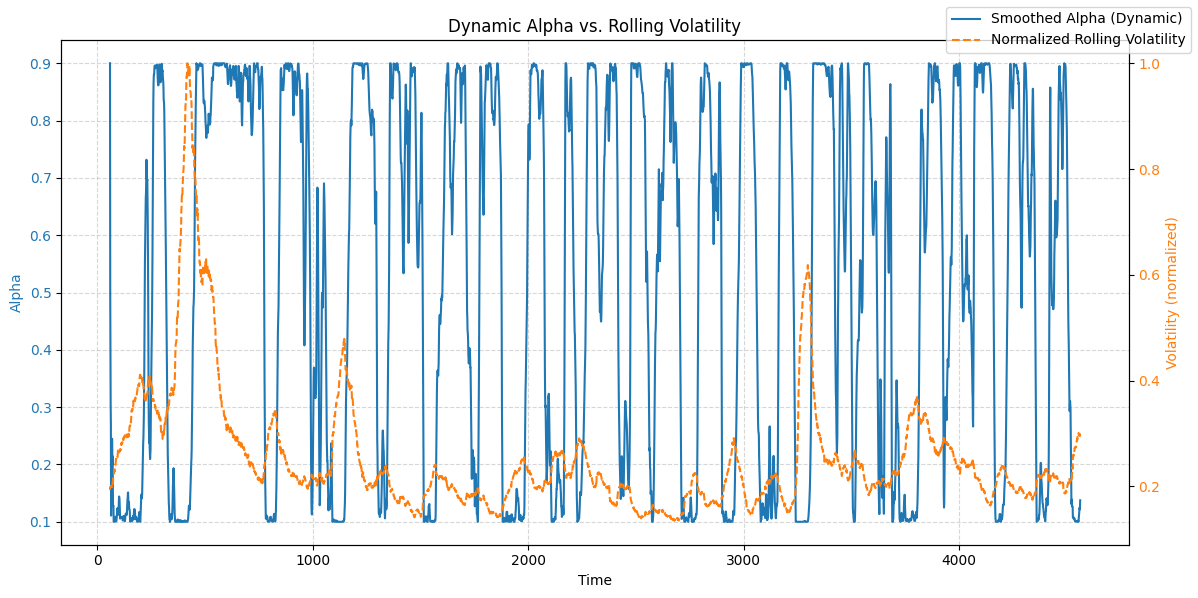

In [275]:
# 修正後的畫法範例
def plot_dynamic_alpha(alpha_series, rolling_vol):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(alpha_series, label='Smoothed Alpha (Dynamic)', color='tab:blue')
    ax1.set_ylabel('Alpha', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(rolling_vol / np.nanmax(rolling_vol), '--', label='Normalized Rolling Volatility', color='tab:orange')
    ax2.set_ylabel('Volatility (normalized)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    ax1.set_title('Dynamic Alpha vs. Rolling Volatility')
    ax1.set_xlabel('Time')
    fig.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_dynamic_alpha(alpha_series, rolling_vol)

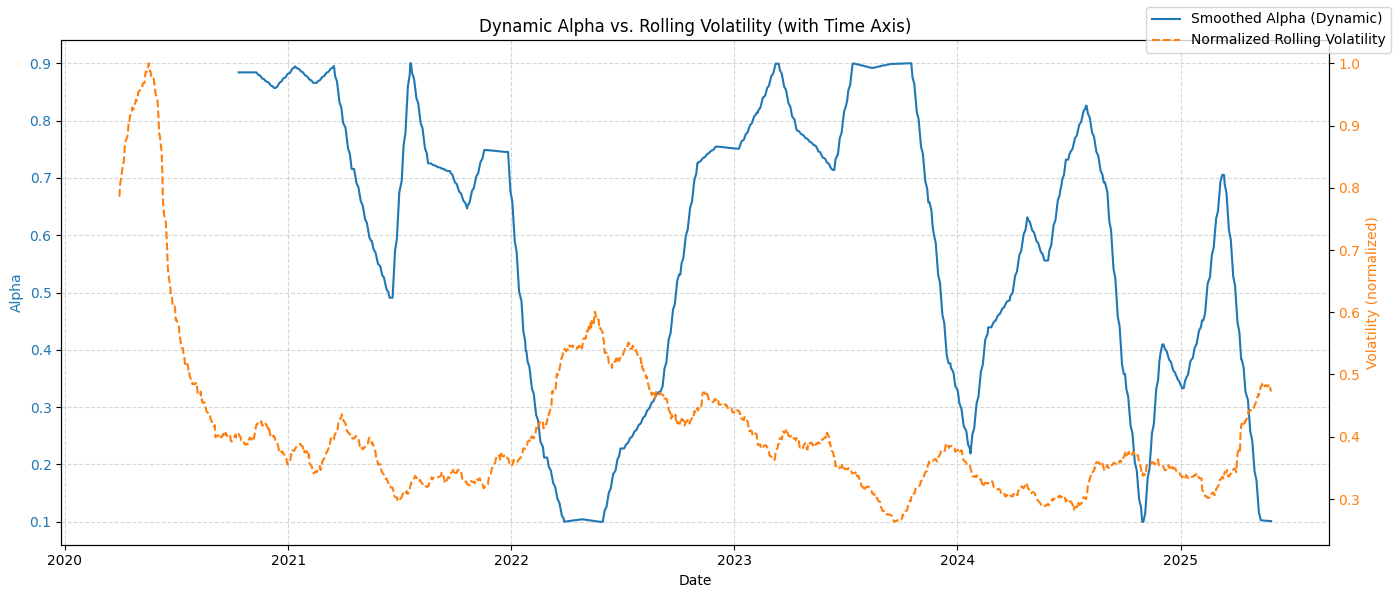

In [191]:
def compute_dynamic_alpha_monthly(returns, vol_window=60, scale_window=180, smooth_window=20,
                                   alpha_min=0.1, alpha_max=0.9):
    """
    每月調整一次 alpha，並以 20 日移動平均平滑。
    """
    T = returns.shape[0]
    vol_series = pd.Series(np.std(returns, axis=1))
    rolling_vol = vol_series.rolling(window=vol_window, min_periods=vol_window).mean()

    alpha_raw = [np.nan] * T
    month_indices = pd.date_range(start="2000-01-01", periods=T, freq="B")  # 假設時間對應
    month_start_flags = pd.Series(month_indices).dt.to_period("M").ne(
        pd.Series(month_indices).shift().dt.to_period("M")
    ).fillna(True)

    for t in range(scale_window, T):
        if not month_start_flags.iloc[t]:
            continue

        vol_t = rolling_vol.iloc[t]
        vol_slice = rolling_vol.iloc[t - scale_window:t+1]
        vol_min = vol_slice.min()
        vol_max = vol_slice.max()
        denom = vol_max - vol_min + 1e-8
        scaled = (vol_t - vol_min) / denom
        alpha_t = alpha_max - (alpha_max - alpha_min) * scaled

        # 將此 alpha 應用於整個月（直到下一個月初）
        next_change = t + 1
        while next_change < T and not month_start_flags.iloc[next_change]:
            next_change += 1
        for i in range(t, min(next_change, T)):
            alpha_raw[i] = alpha_t

    alpha_series = pd.Series(alpha_raw).rolling(window=smooth_window, min_periods=1).mean()
    alpha_clipped = alpha_series.clip(lower=alpha_min, upper=alpha_max)

    return alpha_clipped.values, rolling_vol.values

# 執行並繪圖檢查
alpha_monthly, rolling_vol_monthly = compute_dynamic_alpha_monthly(R)
plot_dynamic_alpha_with_dates(alpha_monthly, rolling_vol_monthly, dates=returns.index)


In [ ]:
from tqdm import tqdm

def run_erc_backtest_with_marginal_gradient(returns, alpha_series, window=60, beta=0.95, max_weight=0.2):
    T, N = returns.shape
    weight_history = []
    portfolio_returns = []

    for t in tqdm(range(window, T)):
        R_window = returns[t - window: t]
        alpha_t = alpha_series[t]

        try:
            weights, _ = optimize_hybrid_erc(R_window, alpha=alpha_t, beta=beta, max_weight=max_weight)
        except:
            weights = np.ones(N) / N

        weight_history.append(weights)
        portfolio_returns.append(np.dot(returns[t], weights))

    return np.array(weight_history), np.array(portfolio_returns)

def run_fixed_alpha_backtest(returns, alpha=0.5, **kwargs):
    alpha_series = np.full(returns.shape[0], alpha)
    return run_erc_backtest_with_marginal_gradient(returns, alpha_series, **kwargs)

In [ ]:
from tqdm import tqdm

def run_dynamic_hybrid_erc_backtest(returns, alpha_series, upper_bound=0.2):
    """
    根據每期動態 alpha 進行 Hybrid ERC 最佳化，回傳每期權重與報酬。
    """
    T, N = returns.shape
    weight_history = []
    portfolio_returns = []

    for t in tqdm(range(len(alpha_series))):
        alpha = alpha_series[t]
        R_slice = returns[max(0, t-60):t+1, :]  # 使用過去 60 天進行估計
        if R_slice.shape[0] < 30:
            weight_history.append(np.full(N, 1/N))  # 不足資料則均分配置
            portfolio_returns.append(np.dot(returns[t], weight_history[-1]))
            continue

        try:
            w = cp.Variable(N)
            L = -R_slice @ w

            # MAD
            mean_loss = cp.sum(L) / R_slice.shape[0]
            mad = cp.sum(cp.abs(L - mean_loss)) / R_slice.shape[0]

            # CVaR
            zeta = cp.Variable()
            slack = cp.Variable(R_slice.shape[0])
            cvar = zeta + cp.sum(slack) / ((1 - 0.95) * R_slice.shape[0])
            cvar_constraints = [slack >= 0, slack >= L - zeta]

            hybrid_risk = alpha * mad + (1 - alpha) * cvar
            constraints = [cp.sum(w) == 1, w >= 0, w <= upper_bound] + cvar_constraints

            prob = cp.Problem(cp.Minimize(hybrid_risk), constraints)
            prob.solve(solver=cp.SCS)

            if w.value is not None and prob.status == 'optimal':
                weight = w.value
            else:
                weight = np.full(N, 1/N)
        except:
            weight = np.full(N, 1/N)

        weight_history.append(weight)
        portfolio_returns.append(np.dot(returns[t], weight))

    return np.array(weight_history), np.array(portfolio_returns)


# 同時建構固定 α = 0.5 的回測
def run_fixed_alpha_backtest(returns, alpha=0.5, upper_bound=0.2):
    alpha_series = np.full(returns.shape[0], alpha)
    return run_dynamic_hybrid_erc_backtest(returns, alpha_series, upper_bound)


In [2]:
# 動態 alpha 策略
w_dynamic, r_dynamic = run_dynamic_hybrid_erc_backtest(R, alpha_series)

# 固定 alpha 策略
w_fixed, r_fixed = run_fixed_alpha_backtest(R, alpha=0.5)
w_fixed, r_fixed = run_fixed_alpha_backtest(R, alpha=0.1)

NameError: name 'run_dynamic_hybrid_erc_backtest' is not defined

In [276]:
# 動態 alpha 策略
w_dynamic, r_dynamic = run_erc_backtest_with_marginal_gradient(R, alpha_series)

# 固定 alpha 策略
w_fixed, r_fixed = run_fixed_alpha_backtest(R, alpha=0.5)

100%|██████████| 4503/4503 [00:16<00:00, 277.30it/s]


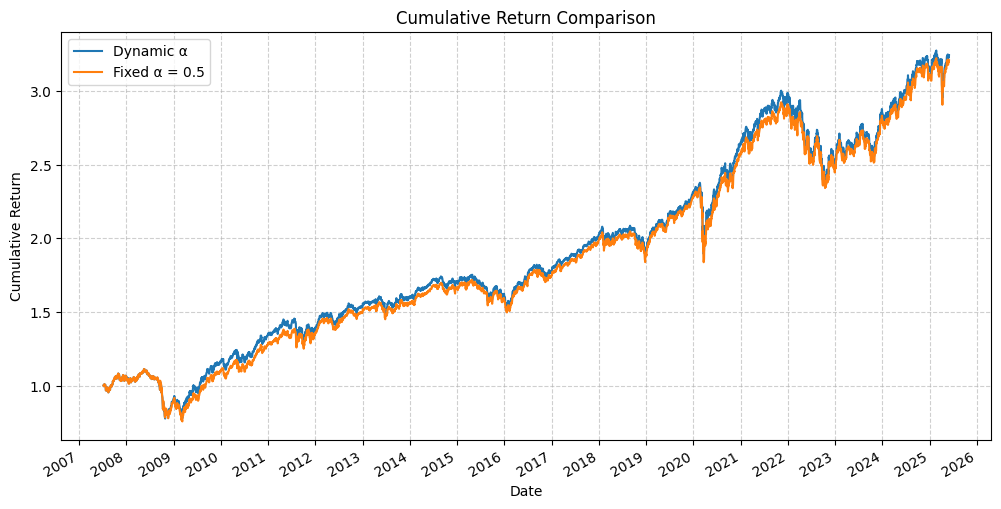

In [277]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_cumulative_returns(r1, r2, dates=None, labels=["Dynamic α", "Fixed α = 0.5"]):
    """
    r1, r2: 報酬率序列（長度 T）
    dates: datetime 日期序列（長度 T，可選）
    labels: 策略名稱
    """
    cum_r1 = np.cumprod(1 + r1)
    cum_r2 = np.cumprod(1 + r2)

    plt.figure(figsize=(12, 6))

    if dates is not None:
        plt.plot(dates[-len(cum_r1):], cum_r1, label=labels[0])
        plt.plot(dates[-len(cum_r2):], cum_r2, label=labels[1])
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # 每年一格
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.gcf().autofmt_xdate()
        plt.xlabel("Date")
    else:
        plt.plot(cum_r1, label=labels[0])
        plt.plot(cum_r2, label=labels[1])
        plt.xlabel("Time")

    plt.title("Cumulative Return Comparison")
    plt.ylabel("Cumulative Return")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# 假設 returns 是從第 60 天開始回測的：
plot_cumulative_returns(r_dynamic, r_fixed, dates=returns.index)

In [278]:
def compute_metrics(returns, rf=0.0001, scale=252):
    ann_return = np.mean(returns) * scale
    ann_vol = np.std(returns) * np.sqrt(scale)
    sharpe = (ann_return - rf) / ann_vol if ann_vol > 0 else np.nan
    cumulative = np.cumprod(1 + returns)
    drawdowns = 1 - cumulative / np.maximum.accumulate(cumulative)
    max_drawdown = np.max(drawdowns)
    return {
        "Annual Return": ann_return,
        "Volatility": ann_vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_drawdown
    }

print("Dynamic α Performance:", compute_metrics(r_dynamic))
print("Fixed α Performance:", compute_metrics(r_fixed))


Dynamic α Performance: {'Annual Return': np.float64(0.07210093834386794), 'Volatility': np.float64(0.1119338065833802), 'Sharpe': np.float64(0.6432456872645886), 'Max Drawdown': np.float64(0.3014180214214064)}
Fixed α Performance: {'Annual Return': np.float64(0.07172401838958833), 'Volatility': np.float64(0.1138542742471426), 'Sharpe': np.float64(0.6290850199801425), 'Max Drawdown': np.float64(0.31917656627821445)}


回測各策略報酬與風險表現

100%|██████████| 4503/4503 [00:13<00:00, 336.55it/s]


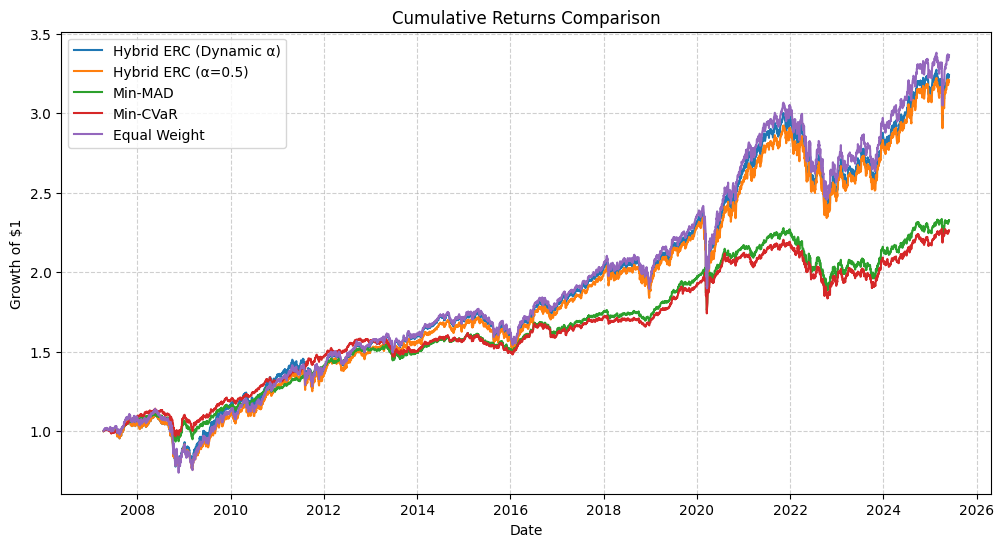

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 評估指標計算函數
def compute_metrics(returns, rf=0.0001, scale=252):
    """
    計算年化報酬、波動度、Sharpe、最大回撤
    """
    ann_return = np.mean(returns) * scale
    ann_vol = np.std(returns) * np.sqrt(scale)
    sharpe = (ann_return - rf) / ann_vol if ann_vol > 0 else np.nan

    cumulative = np.cumprod(1 + returns)
    running_max = np.maximum.accumulate(cumulative)
    drawdowns = 1 - cumulative / running_max
    max_drawdown = np.max(drawdowns)

    return {
        "Annual Return": ann_return,
        "Volatility": ann_vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_drawdown
    }

# 策略報酬字典與績效表整理
def summarize_strategies(strategy_returns_dict):
    summary = pd.DataFrame()
    for name, rets in strategy_returns_dict.items():
        metrics = compute_metrics(rets)
        summary[name] = pd.Series(metrics)
    return summary.T

# 累積報酬視覺化
def plot_cumulative_returns(strategy_returns_dict, dates=None):
    plt.figure(figsize=(12, 6))
    for name, rets in strategy_returns_dict.items():
        cumrets = np.cumprod(1 + rets)
        if dates is not None:
            plt.plot(dates[-len(cumrets):], cumrets, label=name)
        else:
            plt.plot(cumrets, label=name)
    plt.title("Cumulative Returns Comparison")
    plt.ylabel("Growth of $1")
    plt.xlabel("Date" if dates is not None else "Time")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()



# 執行所有策略（Hybrid 動態、固定、Min-MAD、Min-CVaR、MAD-ERC、CVaR-ERC、EW）
def run_benchmark_strategies(returns, alpha_series, alpha_fixed=0.5):
    T, N = returns.shape
    equal_weight = np.repeat(1 / N, N)
    rets_equal = returns @ equal_weight

    # Hybrid ERC: dynamic and fixed alpha
    _, rets_dynamic = run_erc_backtest_with_marginal_gradient(returns, alpha_series)
    _, rets_fixed = run_fixed_alpha_backtest(returns, alpha_fixed)

    # Min-MAD
    w = cp.Variable(N)
    L = -returns
    mean_loss = cp.sum(L @ w) / T
    mad = cp.sum(cp.abs(L @ w - mean_loss)) / T
    prob = cp.Problem(cp.Minimize(mad), [cp.sum(w) == 1, w >= 0, w <= 0.2])
    prob.solve()
    w_mad = w.value
    rets_minmad = returns @ w_mad

    # Min-CVaR
    w = cp.Variable(N)
    zeta = cp.Variable()
    slack = cp.Variable(T)
    loss = -returns @ w
    cvar = zeta + cp.sum(slack) / ((1 - 0.95) * T)
    constraints = [slack >= 0, slack >= loss - zeta, cp.sum(w) == 1, w >= 0, w <= 0.2]
    prob = cp.Problem(cp.Minimize(cvar), constraints)
    prob.solve()
    w_cvar = w.value
    rets_mincvar = returns @ w_cvar

    # MAD-ERC、CVaR-ERC


    strategy_dict = {
        "Hybrid ERC (Dynamic α)": rets_dynamic,
        "Hybrid ERC (α=0.5)": rets_fixed,
        "Min-MAD": rets_minmad,
        "Min-CVaR": rets_mincvar,
        "Equal Weight": rets_equal
    }

    return strategy_dict, w_mad, w_cvar


# 執行策略與統整績效
strategy_returns_dict, w_mad, w_cvar = run_benchmark_strategies(R, alpha_series)
performance_summary = summarize_strategies(strategy_returns_dict)
plot_cumulative_returns(strategy_returns_dict, dates=returns.index)


In [ ]:
def compute_metrics(returns, rf=0.0001, scale=252):
    ann_return = np.mean(returns) * scale
    ann_vol = np.std(returns) * np.sqrt(scale)
    sharpe = (ann_return - rf) / ann_vol if ann_vol > 0 else np.nan
    cumulative = np.cumprod(1 + returns)
    running_max = np.maximum.accumulate(cumulative)
    drawdowns = 1 - cumulative / running_max
    max_drawdown = np.max(drawdowns)
    return {
        "Annual Return": ann_return,
        "Volatility": ann_vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_drawdown
    }

def summarize_strategies(strategy_returns_dict):
    summary = pd.DataFrame()
    for name, rets in strategy_returns_dict.items():
        metrics = compute_metrics(rets)
        summary[name] = pd.Series(metrics)
    return summary.T

def plot_cumulative_returns(strategy_returns_dict, dates=None):
    plt.figure(figsize=(12, 6))
    for name, rets in strategy_returns_dict.items():
        cumrets = np.cumprod(1 + rets)
        if dates is not None:
            plt.plot(dates[-len(cumrets):], cumrets, label=name)
        else:
            plt.plot(cumrets, label=name)
    plt.title("Cumulative Returns Comparison")
    plt.ylabel("Growth of $1")
    plt.xlabel("Date" if dates is not None else "Time")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# Hybrid ERC (Dynamic α)
def run_erc_backtest_with_marginal_gradient(returns, alpha_series, window=60, beta=0.95, max_weight=0.2):
    T, N = returns.shape
    weight_history = []
    portfolio_returns = []

    for t in range(window, T):
        R_window = returns[t - window: t]
        alpha_t = alpha_series[t]

        weights, _ = optimize_hybrid_erc(R_window, alpha=alpha_t, beta=beta, max_weight=max_weight)
        weight_history.append(weights)
        portfolio_returns.append(np.dot(returns[t], weights))

    return np.array(weight_history), np.array(portfolio_returns)

def optimize_hybrid_erc(R, alpha=0.5, beta=0.95, max_weight=0.2):
    T, N = R.shape
    ew = np.ones(N) / N
    L_ew = -R @ ew
    mad_ew = np.mean(np.abs(L_ew - np.mean(L_ew)))
    zeta_ew = np.percentile(L_ew, (1 - beta) * 100)
    slack_ew = np.maximum(0, L_ew - zeta_ew)
    cvar_ew = zeta_ew + np.sum(slack_ew) / ((1 - beta) * T)

    def compute_grad(w):
        L = -R @ w
        mu = np.mean(L)
        grad_mad = np.mean(np.sign(L - mu).reshape(-1, 1) * -R, axis=0)
        zeta = np.percentile(L, (1 - beta) * 100)
        tail_idx = np.where(L > zeta)[0]
        grad_cvar = -np.mean(R[tail_idx], axis=0) / (1 - beta) if len(tail_idx) > 0 else np.zeros(N)
        return alpha * grad_mad / mad_ew + (1 - alpha) * grad_cvar / cvar_ew

    def loss(w):
        grad = compute_grad(w)
        rc = w * grad
        return np.sum((rc - rc.mean()) ** 2)

    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, max_weight) for _ in range(N)]
    w0 = np.ones(N) / N
    result = minimize(loss, w0, method='SLSQP', bounds=bounds, constraints=cons)
    return result.x, loss(result.x)

# 傳統 ERC（用變異數衡量）
def variance_erc_weights(R):
    cov = np.cov(R.T)
    N = cov.shape[0]
    def objective(w):
        contrib = w * (cov @ w)
        return np.sum((contrib - contrib.mean())**2)
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 0.2)] * N
    w0 = np.ones(N) / N
    res = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x

# MAD-ERC
def mad_erc_weights(R):
    T, N = R.shape
    def marginal_grad(w):
        L = -R @ w
        mu = np.mean(L)
        return np.mean(np.sign(L - mu).reshape(-1, 1) * -R, axis=0)
    def loss(w):
        grad = marginal_grad(w)
        rc = w * grad
        return np.sum((rc - rc.mean()) ** 2)
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 0.2)] * N
    w0 = np.ones(N) / N
    res = minimize(loss, w0, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x

# CVaR-ERC
def cvar_erc_weights(R, beta=0.95):
    T, N = R.shape
    def marginal_grad(w):
        L = -R @ w
        zeta = np.percentile(L, (1 - beta) * 100)
        tail_idx = np.where(L > zeta)[0]
        return -np.mean(R[tail_idx], axis=0) / (1 - beta) if len(tail_idx) > 0 else np.zeros(N)
    def loss(w):
        grad = marginal_grad(w)
        rc = w * grad
        return np.sum((rc - rc.mean()) ** 2)
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 0.2)] * N
    w0 = np.ones(N) / N
    res = minimize(loss, w0, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x



In [175]:
def run_all_strategies(R, alpha_series):
    T, N = R.shape
    strategy_returns = {}

    # Hybrid ERC (dynamic)
    _, rets_dynamic = run_erc_backtest_with_marginal_gradient(R, alpha_series)
    strategy_returns["Hybrid ERC (Dynamic α)"] = rets_dynamic

    # Equal Weight
    ew = np.ones(N) / N
    strategy_returns["Equal Weight"] = R @ ew

    # Variance-ERC
    w_var = variance_erc_weights(R)
    strategy_returns["Variance ERC"] = R @ w_var

    # MAD-ERC
    w_mad = mad_erc_weights(R)
    strategy_returns["MAD ERC"] = R @ w_mad

    # CVaR-ERC
    w_cvar = cvar_erc_weights(R)
    strategy_returns["CVaR ERC"] = R @ w_cvar

    # Min-MAD
    w = cp.Variable(N)
    L = -R
    mean_loss = cp.sum(L @ w) / T
    mad = cp.sum(cp.abs(L @ w - mean_loss)) / T
    prob = cp.Problem(cp.Minimize(mad), [cp.sum(w) == 1, w >= 0, w <= 0.2])
    prob.solve()
    strategy_returns["Min-MAD"] = R @ w.value

    # Min-CVaR
    w = cp.Variable(N)
    zeta = cp.Variable()
    slack = cp.Variable(T)
    loss = -R @ w
    cvar = zeta + cp.sum(slack) / ((1 - 0.95) * T)
    constraints = [slack >= 0, slack >= loss - zeta, cp.sum(w) == 1, w >= 0, w <= 0.2]
    prob = cp.Problem(cp.Minimize(cvar), constraints)
    prob.solve()
    strategy_returns["Min-CVaR"] = R @ w.value

    # Max Mean-Var (sharpe)
    mu = np.mean(R, axis=0)
    cov = np.cov(R.T)
    w0 = np.ones(N) / N
    def neg_sharpe(w):
        port_mu = np.dot(w, mu)
        port_vol = np.sqrt(np.dot(w.T, cov @ w))
        return -port_mu / port_vol
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 0.2)] * N
    res = minimize(neg_sharpe, w0, method='SLSQP', bounds=bounds, constraints=cons)
    strategy_returns["Max Mean-Var"] = R @ res.x

    return strategy_returns


In [174]:
def safe_optimize(objective, N, bounds=None):
    w0 = np.ones(N) / N
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    result = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=cons)
    if not result.success:
        print("⚠️ Optimization failed. Fallback to Equal Weight.")
        return w0
    return result.x

def mad_erc_weights(R):
    T, N = R.shape
    def marginal_grad(w):
        L = -R @ w
        mu = np.mean(L)
        return np.mean(np.sign(L - mu).reshape(-1, 1) * -R, axis=0)
    def loss(w):
        grad = marginal_grad(w)
        rc = w * grad
        return np.sum((rc - rc.mean()) ** 2)
    bounds = [(0, 0.2)] * N
    return safe_optimize(loss, N, bounds)

def variance_erc_weights(R):
    cov = np.cov(R.T)
    N = cov.shape[0]
    def objective(w):
        contrib = w * (cov @ w)
        return np.sum((contrib - contrib.mean())**2)
    bounds = [(0, 0.2)] * N
    return safe_optimize(objective, N, bounds)

def cvar_erc_weights(R, beta=0.95):
    T, N = R.shape
    def marginal_grad(w):
        L = -R @ w
        zeta = np.percentile(L, (1 - beta) * 100)
        tail_idx = np.where(L > zeta)[0]
        return -np.mean(R[tail_idx], axis=0) / (1 - beta) if len(tail_idx) > 0 else np.zeros(N)
    def loss(w):
        grad = marginal_grad(w)
        rc = w * grad
        return np.sum((rc - rc.mean()) ** 2)
    bounds = [(0, 0.2)] * N
    return safe_optimize(loss, N, bounds)



In [171]:
from scipy.optimize import minimize

# --- Variance-ERC ---
def variance_erc_weights(R):
    cov = np.cov(R.T)
    N = cov.shape[0]
    def objective(w):
        contrib = w * (cov @ w)
        return np.sum((contrib - contrib.mean())**2)
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 0.2)] * N
    w0 = np.ones(N) / N
    res = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x

# --- MAD-ERC ---
def mad_erc_weights(R):
    T, N = R.shape
    def marginal_grad(w):
        L = -R @ w
        mu = np.mean(L)
        return np.mean(np.sign(L - mu).reshape(-1, 1) * -R, axis=0)
    def loss(w):
        grad = marginal_grad(w)
        rc = w * grad
        return np.sum((rc - rc.mean()) ** 2)
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 0.2)] * N
    w0 = np.ones(N) / N
    res = minimize(loss, w0, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x

# --- CVaR-ERC ---
def cvar_erc_weights(R, beta=0.95):
    T, N = R.shape
    def marginal_grad(w):
        L = -R @ w
        zeta = np.percentile(L, (1 - beta) * 100)
        tail_idx = np.where(L > zeta)[0]
        return -np.mean(R[tail_idx], axis=0) / (1 - beta) if len(tail_idx) > 0 else np.zeros(N)
    def loss(w):
        grad = marginal_grad(w)
        rc = w * grad
        return np.sum((rc - rc.mean()) ** 2)
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 0.2)] * N
    w0 = np.ones(N) / N
    res = minimize(loss, w0, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x


100%|██████████| 1298/1298 [00:03<00:00, 357.29it/s]


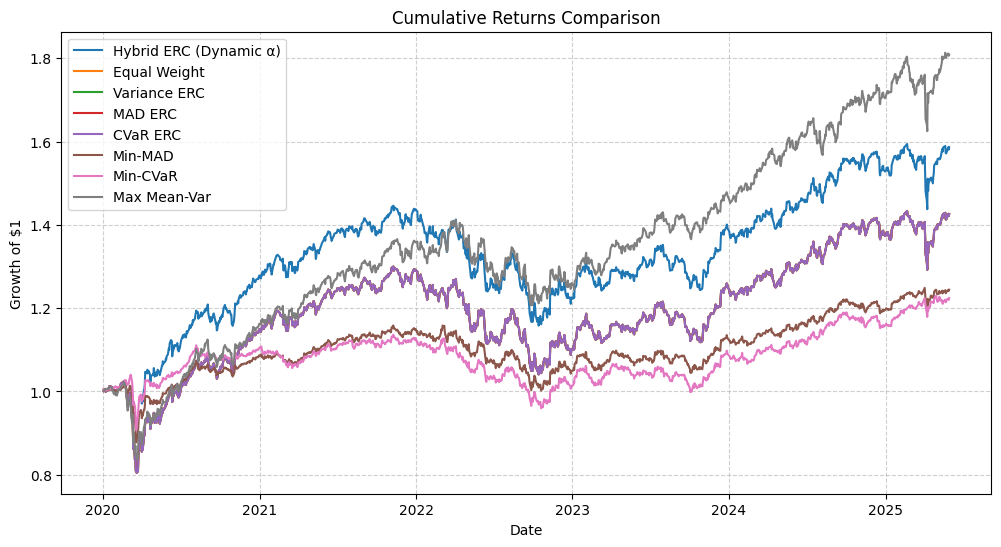

In [176]:
# 假設 R 是 returns（T x N），alpha_series 是同長度 array
strategy_dict = run_all_strategies(R, alpha_series)
performance_summary = summarize_strategies(strategy_dict)
plot_cumulative_returns(strategy_dict, dates=returns.index)

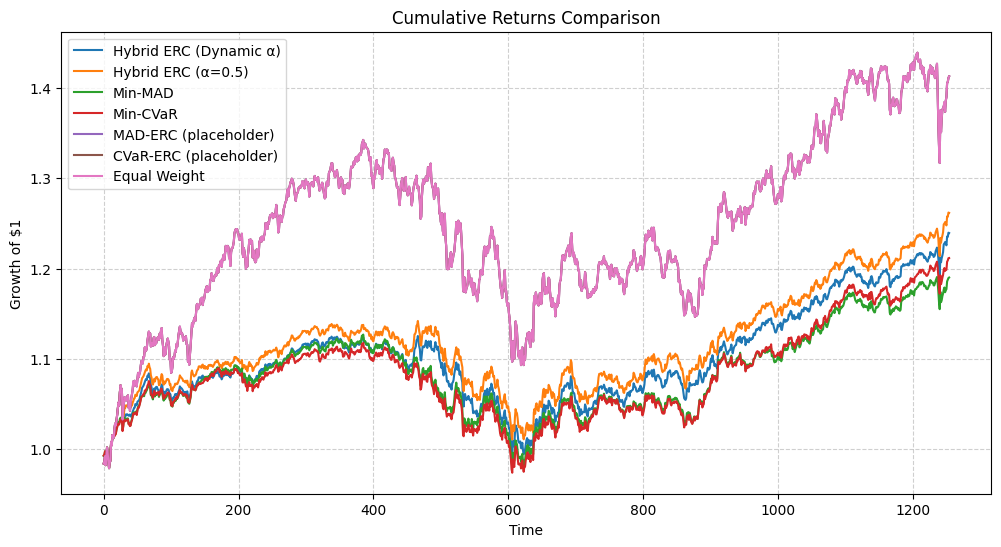

In [31]:
plot_cumulative_returns(strategy_returns_dict)

In [280]:
import pandas as pd
from IPython.display import display

performance_summary_sorted = performance_summary.sort_values("Sharpe", ascending=False)
display(performance_summary_sorted.style.format("{:.4f}"))


,Annual Return,Volatility,Sharpe,Max Drawdown
Min-MAD,0.0487,0.0634,0.7658,0.1720
Min-CVaR,0.0471,0.0627,0.7490,0.1674
Hybrid ERC (Dynamic α),0.0721,0.1119,0.6432,0.3014
Hybrid ERC (α=0.5),0.0717,0.1139,0.6291,0.3192
Equal Weight,0.0745,0.1221,0.6093,0.3517


In [39]:
from scipy.optimize import minimize

def solve_erc_objective(R, compute_marginal_fn, w0=None, tol=1e-6, max_iter=1000):
    T, N = R.shape
    if w0 is None:
        w0 = np.repeat(1 / N, N)

    def loss(w):
        w = np.clip(w, 1e-6, 1)
        mrc = compute_marginal_fn(w, R)
        rc = w * mrc
        target = np.mean(rc)
        return np.sum((rc - target)**2)

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 0.3)] * N

    result = minimize(loss, w0, bounds=bounds, constraints=constraints)
    return result.x if result.success else w0


In [ ]:
from scipy.optimize import minimize

# === 補上 MAD/CVaR Marginal Risk Contribution ===
def compute_mad_marginal(w, R):
    T = R.shape[0]
    L = -R @ w
    mu = np.mean(L)
    sign_vec = np.sign(L - mu).reshape(-1, 1)
    grad_L = -R
    grad_mad = (1 / T) * np.sum(sign_vec * grad_L, axis=0)
    return grad_mad

def compute_cvar_marginal(w, R, beta=0.95):
    T = R.shape[0]
    L = -R @ w
    zeta = np.percentile(L, (1 - beta) * 100)
    tail_idx = np.where(L > zeta)[0]
    if len(tail_idx) == 0:
        return np.zeros(R.shape[1])
    grad_cvar = (-1 / ((1 - beta) * T)) * np.sum(R[tail_idx, :], axis=0)
    return grad_cvar

# === ERC Objective Function ===
def erc_objective(w, R, risk_type="mad"):
    if risk_type == "mad":
        mrc = compute_mad_marginal(w, R)
    elif risk_type == "cvar":
        mrc = compute_cvar_marginal(w, R)
    else:
        raise ValueError("risk_type must be 'mad' or 'cvar'")
    mean_mrc = np.mean(mrc)
    return np.sum((mrc - mean_mrc)**2)

# === Solve ERC for MAD / CVaR ===
def solve_erc(R, risk_type="mad"):
    N = R.shape[1]
    w0 = np.repeat(1/N, N)
    bounds = [(0, 0.3)] * N
    constraints = [{"type": "eq", "fun": lambda w: np.sum(w) - 1}]
    result = minimize(erc_objective, w0, args=(R, risk_type), method='SLSQP',
                      bounds=bounds, constraints=constraints)
    return result.x if result.success else np.repeat(1/N, N)

# 更新後的 run_benchmark_strategies
def run_benchmark_strategies(returns, alpha_series, alpha_fixed=0.5):
    T, N = returns.shape
    equal_weight = np.repeat(1 / N, N)
    rets_equal = returns @ equal_weight

    # Hybrid ERC: dynamic and fixed alpha
    _, rets_dynamic = run_dynamic_hybrid_erc_backtest(returns, alpha_series)
    _, rets_fixed = run_fixed_alpha_backtest(returns, alpha_fixed)

    # Min-MAD
    w = cp.Variable(N)
    L = -returns
    mean_loss = cp.sum(L @ w) / T
    mad = cp.sum(cp.abs(L @ w - mean_loss)) / T
    prob = cp.Problem(cp.Minimize(mad), [cp.sum(w) == 1, w >= 0, w <= 0.3])
    prob.solve()
    w_mad = w.value
    rets_minmad = returns @ w_mad

    # Min-CVaR
    w = cp.Variable(N)
    zeta = cp.Variable()
    slack = cp.Variable(T)
    loss = -returns @ w
    cvar = zeta + cp.sum(slack) / ((1 - 0.95) * T)
    constraints = [slack >= 0, slack >= loss - zeta, cp.sum(w) == 1, w >= 0, w <= 0.3]
    prob = cp.Problem(cp.Minimize(cvar), constraints)
    prob.solve()
    w_cvar = w.value
    rets_mincvar = returns @ w_cvar

    # True MAD-ERC & CVaR-ERC
    w_erc_mad = solve_erc_objective(returns, compute_mad_marginal)
    w_erc_cvar = solve_erc_objective(returns, compute_cvar_marginal)
    rets_mad_erc = returns @ w_erc_mad
    rets_cvar_erc = returns @ w_erc_cvar

    strategy_dict = {
        "Hybrid ERC (Dynamic α)": rets_dynamic,
        "Hybrid ERC (α=0.5)": rets_fixed,
        "Min-MAD": rets_minmad,
        "Min-CVaR": rets_mincvar,
        "MAD-ERC": rets_mad_erc,
        "CVaR-ERC": rets_cvar_erc,
        "Equal Weight": rets_equal
    }

    return strategy_dict, w_mad, w_cvar, w_erc_mad, w_erc_cvar


In [41]:
def plot_cumulative_returns(strategy_returns_dict, dates=None):
    plt.figure(figsize=(12, 6))
    for name, rets in strategy_returns_dict.items():
        cumrets = np.cumprod(1 + rets)
        if dates is not None:
            plt.plot(dates[-len(cumrets):], cumrets, label=name)
        else:
            plt.plot(cumrets, label=name)
    plt.title("Cumulative Returns Comparison")
    plt.ylabel("Growth of $1")
    plt.xlabel("Date" if dates is not None else "Time")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()


In [42]:
strategy_returns_dict, w_mad, w_cvar, w_erc_mad, w_erc_cvar = run_benchmark_strategies(R, alpha_series)
performance_summary = summarize_strategies(strategy_returns_dict)
plot_cumulative_returns(strategy_returns_dict, dates=R.index)

100%|██████████| 1255/1255 [01:42<00:00, 12.20it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'index'

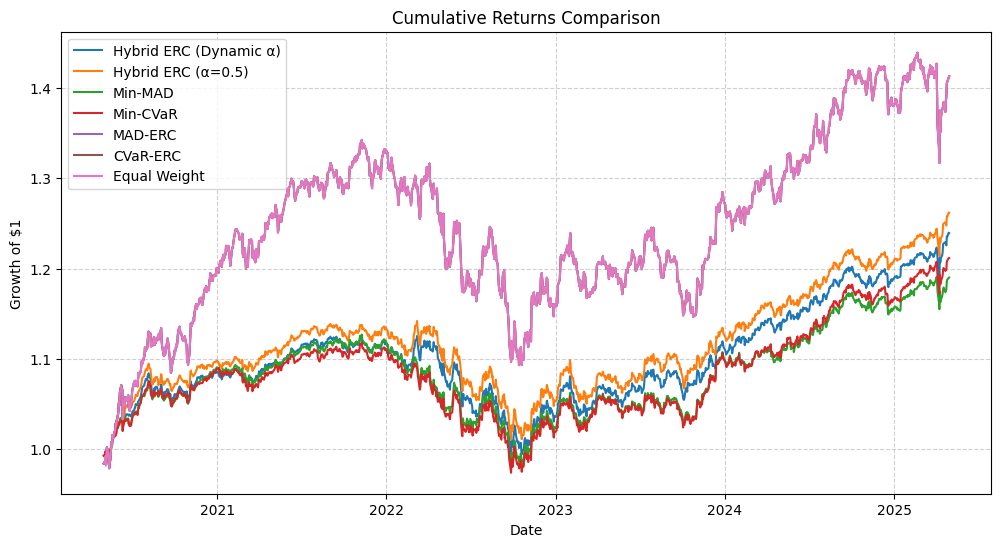

In [43]:
plot_cumulative_returns(strategy_returns_dict, dates=returns.index)

100%|██████████| 1255/1255 [02:50<00:00,  7.36it/s]


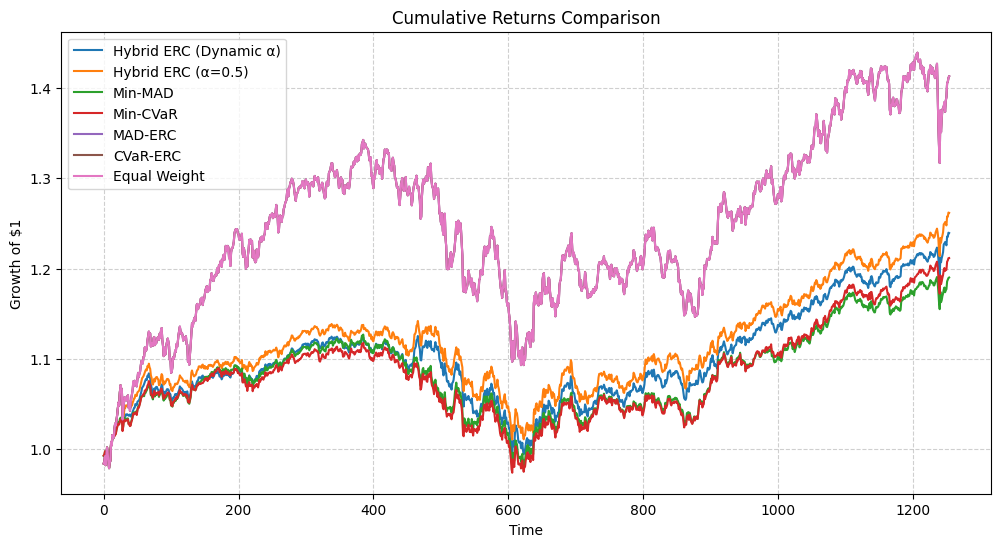

In [36]:
strategy_returns_dict, w_mad, w_cvar, w_erc_mad, w_erc_cvar = run_benchmark_strategies(R, alpha_series)
performance_summary = summarize_strategies(strategy_returns_dict)
plot_cumulative_returns(strategy_returns_dict)

In [44]:
import pandas as pd
from IPython.display import display

performance_summary_sorted = performance_summary.sort_values("Sharpe", ascending=False)
display(performance_summary_sorted.style.format("{:.4f}"))

,Annual Return,Volatility,Sharpe,Max Drawdown
Hybrid ERC (α=0.5),0.0484,0.0579,0.8329,0.1149
Hybrid ERC (Dynamic α),0.0448,0.0578,0.7731,0.1170
MAD-ERC,0.0745,0.1006,0.7388,0.1857
Equal Weight,0.0745,0.1006,0.7388,0.1857
CVaR-ERC,0.0745,0.1006,0.7388,0.1857
Min-CVaR,0.0401,0.0552,0.7242,0.1286
Min-MAD,0.0365,0.0550,0.6607,0.1293


In [281]:
def compute_skewness(w, R):
    """
    計算投資組合的偏態
    """
    L = -R @ w
    mu = np.mean(L)
    sigma = np.std(L)
    if sigma == 0:
        return 0
    skew = np.mean((L - mu)**3) / sigma**3
    return skew

def compute_kurtosis(w, R):
    """
    計算投資組合的峰度
    """
    L = -R @ w
    mu = np.mean(L)
    sigma = np.std(L)
    if sigma == 0:
        return 0
    kurt = np.mean((L - mu)**4) / sigma**4
    return kurt


In [282]:
def erc_loss_extended(w, R, alpha=0.5, beta=0.95, gamma=20, delta=20, mad_ew=None, cvar_ew=None):
    # ERC loss
    RC = risk_contributions(w, R, alpha, beta, mad_ew, cvar_ew)
    RC_mean = np.mean(RC)
    loss_erc = np.sum((RC - RC_mean) ** 2)

    # Downside Skew penalty (只懲罰負偏態)
    skew_penalty = gamma * max(0, -compute_skewness(w, R))

    # Kurtosis penalty
    kurt_penalty = delta * compute_kurtosis(w, R)

    return loss_erc + skew_penalty + kurt_penalty

In [283]:
def optimize_hybrid_erc_extended(R, alpha=0.5, beta=0.95, gamma=20, delta=20, max_weight=0.2):
    n_assets = R.shape[1]

    ew = np.ones(n_assets) / n_assets
    mad_ew = np.mean(np.abs(-R @ ew - np.mean(-R @ ew)))
    L_ew = -R @ ew
    zeta_ew = np.percentile(L_ew, (1 - beta) * 100)
    slack_ew = np.maximum(0, L_ew - zeta_ew)
    cvar_ew = zeta_ew + np.sum(slack_ew) / ((1 - beta) * len(R))

    w0 = ew
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, max_weight)] * n_assets

    result = minimize(
        erc_loss_extended,
        w0,
        args=(R, alpha, beta, gamma, delta, mad_ew, cvar_ew),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    return result.x, erc_loss_extended(result.x, R, alpha, beta, gamma, delta, mad_ew, cvar_ew)


In [284]:
from tqdm import tqdm
import numpy as np

def run_erc_backtest_with_skew_kurt(returns, alpha_series, beta=0.95, gamma=20, delta=20, window=60, max_weight=0.2):
    """
    使用 MAD、CVaR、偏態、峰度 混合風險指標進行 ERC 回測
    """
    T, N = returns.shape
    weight_history = []
    portfolio_returns = []

    for t in tqdm(range(window, T)):
        R_window = returns.iloc[t - window: t]
        alpha_t = alpha_series[t] if isinstance(alpha_series, np.ndarray) else alpha_series.iloc[t]

        try:
            weights, _ = optimize_hybrid_erc_extended(
                R_window,
                alpha=alpha_t,
                beta=beta,
                gamma=gamma,
                delta=delta,
                max_weight=max_weight
            )
        except Exception as e:
            # 若優化失敗則使用等權重
            weights = np.ones(N) / N

        weight_history.append(weights)
        portfolio_returns.append(np.dot(returns.iloc[t], weights))

    return np.array(weight_history), np.array(portfolio_returns)


In [285]:
weights_skewkurt, rets_skewkurt = run_erc_backtest_with_skew_kurt(
    returns,
    alpha_series=alpha_series)

100%|██████████| 4503/4503 [00:06<00:00, 716.94it/s]


In [286]:
strategy_returns_dict["Hybrid ERC (MAD+CVaR+Skew+Kurt)"] = rets_skewkurt

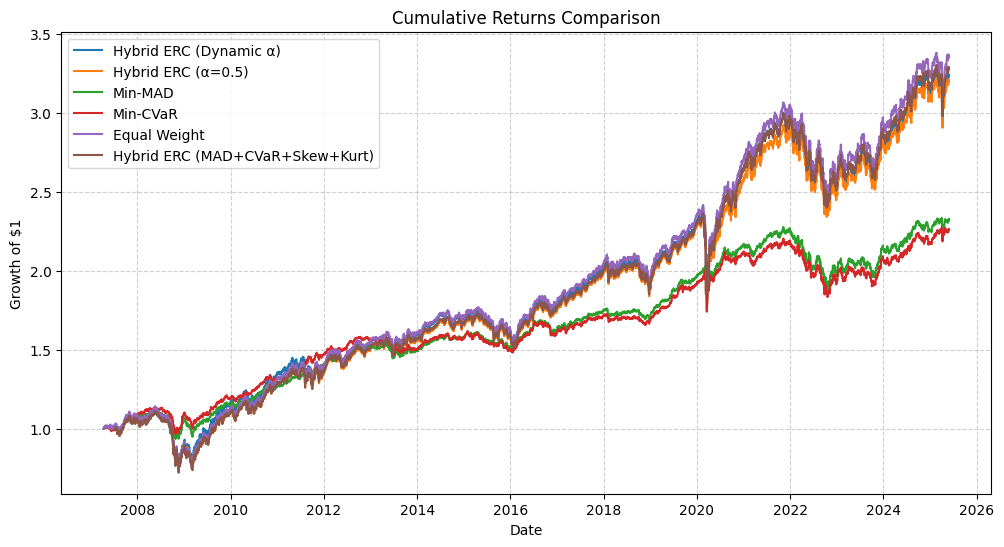

In [287]:
performance_summary = summarize_strategies(strategy_returns_dict)
plot_cumulative_returns(strategy_returns_dict, dates=returns.index)

In [288]:
import pandas as pd
from IPython.display import display

performance_summary_sorted = performance_summary.sort_values("Sharpe", ascending=False)
display(performance_summary_sorted.style.format("{:.4f}"))


,Annual Return,Volatility,Sharpe,Max Drawdown
Min-MAD,0.0487,0.0634,0.7658,0.1720
Min-CVaR,0.0471,0.0627,0.7490,0.1674
Hybrid ERC (Dynamic α),0.0721,0.1119,0.6432,0.3014
Hybrid ERC (α=0.5),0.0717,0.1139,0.6291,0.3192
Equal Weight,0.0745,0.1221,0.6093,0.3517
Hybrid ERC (MAD+CVaR+Skew+Kurt),0.0741,0.1226,0.6041,0.3517


In [289]:
def optimize_hybrid_erc_with_skew_kurt_constraints(R, alpha=0.5, beta=0.95,
                                                    skew_min=-0.2, kurt_max=6.0,
                                                    max_weight=0.2):
    """
    同時最小化 ERC loss，並限制偏態與峰度的 Hybrid ERC 最佳化版本
    """
    N = R.shape[1]
    ew = np.ones(N) / N

    # 計算 baseline normalization 用的 MAD / CVaR 值
    mad_ew = np.mean(np.abs(-R @ ew - np.mean(-R @ ew)))
    L_ew = -R @ ew
    zeta_ew = np.percentile(L_ew, (1 - beta) * 100)
    slack_ew = np.maximum(0, L_ew - zeta_ew)
    cvar_ew = zeta_ew + np.sum(slack_ew) / ((1 - beta) * len(R))

    w0 = ew
    bounds = [(0, max_weight)] * N
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # total weight = 1
        {'type': 'ineq', 'fun': lambda w: compute_skewness(w, R) - skew_min},  # skew ≥ skew_min
        {'type': 'ineq', 'fun': lambda w: kurt_max - compute_kurtosis(w, R)}   # kurt ≤ kurt_max
    ]

    result = minimize(
        erc_loss,  # 原始 ERC loss，只考慮 RC 差異
        w0,
        args=(R, alpha, beta, mad_ew, cvar_ew),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    return result.x, erc_loss(result.x, R, alpha, beta, mad_ew, cvar_ew)


In [290]:
w_constrained, loss_val = optimize_hybrid_erc_with_skew_kurt_constraints(R)


In [291]:
from tqdm import tqdm

def run_erc_backtest_with_constraints(returns, alpha_series, window=60,
                                      skew_min=-0.2, kurt_max=6.0, max_weight=0.2):
    T, N = returns.shape
    weight_history = []
    portfolio_returns = []

    for t in tqdm(range(window, T)):
        R_window = returns.iloc[t - window: t]
        alpha_t = alpha_series[t] if isinstance(alpha_series, np.ndarray) else alpha_series.iloc[t]

        try:
            weights, _ = optimize_hybrid_erc_with_skew_kurt_constraints(
                R_window, alpha=alpha_t, skew_min=skew_min,
                kurt_max=kurt_max, max_weight=max_weight
            )
        except:
            weights = np.ones(N) / N

        weight_history.append(weights)
        portfolio_returns.append(np.dot(returns.iloc[t], weights))

    return np.array(weight_history), np.array(portfolio_returns)


In [292]:
weights_constrained, rets_constrained = run_erc_backtest_with_constraints(returns, alpha_series)
strategy_returns_dict["Hybrid ERC (Skew+Kurt Constraints)"] = rets_constrained


100%|██████████| 4503/4503 [00:08<00:00, 545.75it/s]


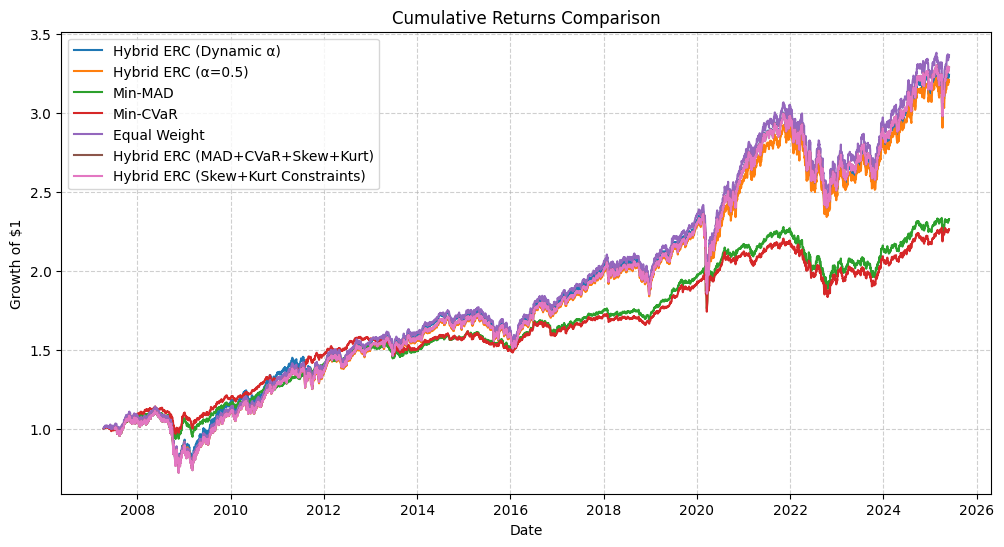

In [293]:
performance_summary = summarize_strategies(strategy_returns_dict)
plot_cumulative_returns(strategy_returns_dict, dates=returns.index)

In [294]:
import pandas as pd
from IPython.display import display

performance_summary_sorted = performance_summary.sort_values("Sharpe", ascending=False)
display(performance_summary_sorted.style.format("{:.4f}"))


,Annual Return,Volatility,Sharpe,Max Drawdown
Min-MAD,0.0487,0.0634,0.7658,0.1720
Min-CVaR,0.0471,0.0627,0.7490,0.1674
Hybrid ERC (Dynamic α),0.0721,0.1119,0.6432,0.3014
Hybrid ERC (α=0.5),0.0717,0.1139,0.6291,0.3192
Equal Weight,0.0745,0.1221,0.6093,0.3517
Hybrid ERC (MAD+CVaR+Skew+Kurt),0.0741,0.1226,0.6041,0.3517
Hybrid ERC (Skew+Kurt Constraints),0.0741,0.1226,0.6041,0.3517
